In [1]:
# ================================================================
# Cell 1 – Imports & project setup
# ================================================================
import os
import sys
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import animation
from IPython.display import HTML

from stable_baselines3 import PPO

# Use CPU only (match training environment)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 6)

# ------------------------------------------------------------------
# Paths (notebooks -> project root)
# ------------------------------------------------------------------
NB_DIR = Path.cwd()
PROJECT_ROOT = NB_DIR.parent

print(f"[INFO] Notebook dir: {NB_DIR}")
print(f"[INFO] Project root: {PROJECT_ROOT}")

# Ensure project root is on sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print("[INFO] Added project root to sys.path")

# Use project root as working directory (for relative paths)
os.chdir(PROJECT_ROOT)
print(f"[INFO] CWD set to: {Path.cwd()}")

# ------------------------------------------------------------------
# Project imports
# ------------------------------------------------------------------
try:
    from sim_rl.cr3bp.scenarios import ScenarioConfig
    from sim_rl.cr3bp.env_cr3bp_station_keeping_repo import (
        Cr3bpStationKeepingEnvRepo,
    )
    from sim_rl.cr3bp_hnn.env_cr3bp_station_keeping_hnn_robust import (
        Cr3bpStationKeepingEnvHNNRobust,
    )
    from sim_rl.cr3bp.constants import (
        SYSTEMS,
        DT,
        LAGRANGE_POINTS,
        SCALE_POS,
        SCALE_VEL,
    )

    print("[SUCCESS] Project modules loaded.")
    print(f"[INFO] Scaling factors -> POS: {SCALE_POS}, VEL: {SCALE_VEL}")
except ImportError as e:
    print(f"[ERROR] Could not import project modules: {e}")
    print("Please check if 'sim_rl' and 'hnn_models' are in the PROJECT_ROOT.")


[INFO] Notebook dir: c:\Users\hosan\Desktop\cr3bp_project_3d\notebooks
[INFO] Project root: c:\Users\hosan\Desktop\cr3bp_project_3d
[INFO] Added project root to sys.path
[INFO] CWD set to: c:\Users\hosan\Desktop\cr3bp_project_3d
[SUCCESS] Project modules loaded.
[INFO] Scaling factors -> POS: 20.0, VEL: 20.0


In [2]:
# ================================================================
# Cell 2 – Run paths & scenario config
# ================================================================
from sim_rl.cr3bp.scenarios import SCENARIOS

# ------------------------------------------------------------------
# Run A – Robust baseline (numerical integrator)
# ------------------------------------------------------------------
TIMESTAMP_BASELINE = "run_20251209_114916"

RUN_DIR_BASELINE = (
    PROJECT_ROOT
    / "sim_rl"
    / "training"
    / "runs_robust"
    / "earth-moon-L1-3D"
    / TIMESTAMP_BASELINE
)
CONFIG_PATH_BASELINE = RUN_DIR_BASELINE / "config" / "run_config.json"
MODEL_PATH_BASELINE = RUN_DIR_BASELINE / "models" / "best_model.zip"

with open(CONFIG_PATH_BASELINE, "r") as f:
    run_cfg_baseline = json.load(f)

print(f"[INFO] Baseline run dir: {RUN_DIR_BASELINE}")

# ------------------------------------------------------------------
# Run B – HNN agent (physics-informed)
# ------------------------------------------------------------------
TIMESTAMP_HNN = "run_20251209_174149"

RUN_DIR_HNN = (
    PROJECT_ROOT
    / "sim_rl"
    / "training"
    / "runs_hnn_robust"
    / "earth-moon-L1-3D"
    / TIMESTAMP_HNN
)
CONFIG_PATH_HNN = RUN_DIR_HNN / "config" / "run_config.json"
MODEL_PATH_HNN = RUN_DIR_HNN / "models" / "best_model.zip"

with open(CONFIG_PATH_HNN, "r") as f:
    run_cfg_hnn = json.load(f)

print(f"[INFO] HNN run dir:      {RUN_DIR_HNN}")

# ------------------------------------------------------------------
# Shared scenario config
# ------------------------------------------------------------------
scenario_name = run_cfg_hnn["scenario"]["name"]

if scenario_name not in SCENARIOS:
    raise ValueError(f"Scenario '{scenario_name}' not found in SCENARIOS registry.")

scenario_cfg = SCENARIOS[scenario_name]
print(f"[INFO] Scenario:         {scenario_cfg.name}")


[INFO] Baseline run dir: c:\Users\hosan\Desktop\cr3bp_project_3d\sim_rl\training\runs_robust\earth-moon-L1-3D\run_20251209_114916
[INFO] HNN run dir:      c:\Users\hosan\Desktop\cr3bp_project_3d\sim_rl\training\runs_hnn_robust\earth-moon-L1-3D\run_20251209_174149
[INFO] Scenario:         earth-moon-L1-3D


In [3]:
# ================================================================
# Cell 3 – Build evaluation environments
# ================================================================

# ------------------------------------------------------------------
# Environment 1 – Repo (ground-truth physics, no robustness noise)
# ------------------------------------------------------------------
env_repo = Cr3bpStationKeepingEnvRepo(
    scenario=scenario_cfg,
    use_reference_orbit=True,
    seed=None,
)
env_repo.max_steps = 6000

print(f"[INFO] env_repo built (RK45). Max steps: {env_repo.max_steps}")

# ------------------------------------------------------------------
# Environment 2 – HNN robust (training domain)
# ------------------------------------------------------------------
env_hnn = Cr3bpStationKeepingEnvHNNRobust(
    scenario=scenario_cfg,
    use_reference_orbit=True,
    seed=None,
)
env_hnn.max_steps = 6000

print(f"[INFO] env_hnn built (HNN).  Max steps: {env_hnn.max_steps}")

# ------------------------------------------------------------------
# Physics constants (for plotting & diagnostics)
# ------------------------------------------------------------------
mu = SYSTEMS[scenario_cfg.system]["mu"]
L1_pos = LAGRANGE_POINTS[scenario_cfg.system][scenario_cfg.lagrange_point]

print(f"[PHYSICS] mu: {mu}, L1: {L1_pos}")


[INFO] env_repo built (RK45). Max steps: 6000
[INFO] env_hnn built (HNN).  Max steps: 6000
[PHYSICS] mu: 0.012150585609624, L1: [0.84059865 0.         0.        ]


In [4]:
# ================================================================
# Cell 4 – Load trained PPO models
# ================================================================

# Load baseline PPO model (numerical physics)
model_baseline = PPO.load(str(MODEL_PATH_BASELINE), env=None, device="cpu")
model_baseline.policy.eval()
print(f"[INFO] Loaded Baseline model: {MODEL_PATH_BASELINE.name}")

# Load HNN-based PPO model (learned dynamics)
model_hnn = PPO.load(str(MODEL_PATH_HNN), env=None, device="cpu")
model_hnn.policy.eval()
print(f"[INFO] Loaded HNN model:      {MODEL_PATH_HNN.name}")


[INFO] Loaded Baseline model: best_model.zip
[INFO] Loaded HNN model:      best_model.zip


In [5]:
# ================================================================
# Cell 5 – Rollout function (with unscaling)
# ================================================================

# Extract scaling factors from config (fallback to constants)
env_cfg = run_cfg_hnn.get("env", {})
SCALE_POS_CFG = env_cfg.get("scale_pos", run_cfg_hnn.get("scale_pos", SCALE_POS))
SCALE_VEL_CFG = env_cfg.get("scale_vel", run_cfg_hnn.get("scale_vel", SCALE_VEL))

print(f"[INFO] Unscale factors -> SCALE_POS={SCALE_POS_CFG:.2e}, SCALE_VEL={SCALE_VEL_CFG:.2e}")

def rollout_with_policy(env, model, n_steps: int = 6000):
    """
    Run a deterministic rollout using a PPO model, unscale the observations,
    and record absolute and relative state histories.
    """
    obs, info = env.reset()
    obs = np.asarray(obs, dtype=float)

    # Infer state dimension (position + velocity)
    dim = obs.shape[0] // 2

    t_list = []
    pos_abs_list = []
    vel_abs_list = []
    rel_pos_list = []
    rel_vel_list = []
    dv_list = []

    t = 0.0
    dt = getattr(env, "dt", DT)

    for _ in range(n_steps):
        # Policy action
        action, _ = model.predict(obs, deterministic=True)

        # Environment step (handles SB3 v1/v2 return formats)
        step_result = env.step(action)
        if len(step_result) == 5:
            obs_next, reward, terminated, truncated, info = step_result
        else:
            obs_next, reward, terminated, info = step_result
            truncated = False

        obs_next = np.asarray(obs_next, dtype=float)

        # Unscale relative position and velocity
        scaled_pos = obs_next[:dim]
        scaled_vel = obs_next[dim:2 * dim]

        rel_pos_phys = scaled_pos / SCALE_POS_CFG
        rel_vel_phys = scaled_vel / SCALE_VEL_CFG

        # Absolute state reconstruction
        if hasattr(env, "target"):
            target = np.asarray(env.target, dtype=float)
        else:
            target = np.zeros(dim, dtype=float)

        pos_abs = target + rel_pos_phys
        vel_abs = rel_vel_phys

        # Logging
        t += float(dt)
        t_list.append(t)
        pos_abs_list.append(pos_abs)
        vel_abs_list.append(vel_abs)
        rel_pos_list.append(rel_pos_phys)
        rel_vel_list.append(rel_vel_phys)
        dv_list.append(np.array(action, copy=True))

        obs = obs_next

        if terminated or truncated:
            break

    return {
        "t": np.array(t_list),
        "pos_rot_abs": np.array(pos_abs_list),
        "vel_rot_abs": np.array(vel_abs_list),
        "rel_pos": np.array(rel_pos_list),
        "rel_vel": np.array(rel_vel_list),
        "dv": np.array(dv_list),
    }

print("[INFO] Rollout function defined.")


[INFO] Unscale factors -> SCALE_POS=2.00e+01, SCALE_VEL=2.00e+01
[INFO] Rollout function defined.


In [ ]:
# ================================================================
# Cell 6 – Robust evaluation environments
# ================================================================
from sim_rl.cr3bp.env_cr3bp_station_keeping_robust import Cr3bpStationKeepingEnvRobust

# Fixed external disturbance in dimensionless CR3BP units
DISTURBANCE_MAG = 1e-7
print(f"[INFO] Using external disturbance: {DISTURBANCE_MAG}")

# ------------------------------------------------------------------
# Robust environment for baseline agent
# ------------------------------------------------------------------
print("[INFO] Creating robust baseline environment...")
env_baseline = Cr3bpStationKeepingEnvRobust(scenario=scenario_cfg)
env_baseline.dist_acc_mag = DISTURBANCE_MAG
env_baseline.mu_uncertainty = 0.0
env_baseline.max_steps = 6000

# ------------------------------------------------------------------
# Robust environment for HNN agent
# ------------------------------------------------------------------
print("[INFO] Creating robust HNN environment...")
env_hnn = Cr3bpStationKeepingEnvRobust(scenario=scenario_cfg)
env_hnn.dist_acc_mag = DISTURBANCE_MAG
env_hnn.mu_uncertainty = 0.0
env_hnn.max_steps = 6000

print("[INFO] Both environments ready (identical disturbance settings).")


[INFO] Using external disturbance: 1e-07
[INFO] Creating robust baseline environment...
[INFO] Creating robust HNN environment...
[INFO] Both environments ready (identical disturbance settings).


In [7]:
# ================================================================
# Cell 7 – Execute rollouts
# ================================================================

# Baseline agent rollout
print("[INFO] Running baseline rollout...")
rollout_base = rollout_with_policy(env_baseline, model_baseline, n_steps=6000)
print(f"[INFO] Baseline finished. Steps: {len(rollout_base['t'])}")

# HNN agent rollout
print("[INFO] Running HNN rollout...")
rollout_hnn = rollout_with_policy(env_hnn, model_hnn, n_steps=6000)
print(f"[INFO] HNN finished. Steps: {len(rollout_hnn['t'])}")


[INFO] Running baseline rollout...
[INFO] Baseline finished. Steps: 6000
[INFO] Running HNN rollout...
[INFO] HNN finished. Steps: 6000


[INFO] env_free built (RK45, rotating frame). Max steps: 6000
[INFO] Running free-drift rollout (no control)...
[INFO] Free-drift finished. Steps: 2850


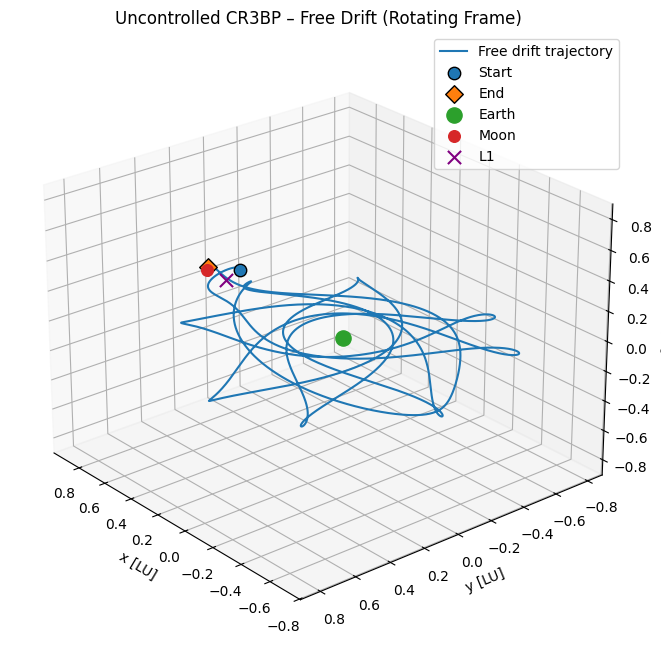

In [8]:
# ================================================================
# Cell 8 – Uncontrolled CR3BP free drift (rotating frame)
# ================================================================

# ---------------------------------------------------------------
# 1. Build pure-physics environment (no control, no robustness)
# ---------------------------------------------------------------
env_free = Cr3bpStationKeepingEnvRepo(
    scenario=scenario_cfg,
    use_reference_orbit=True,
    seed=None,
)
env_free.max_steps = 6000

print(f"[INFO] env_free built (RK45, rotating frame). Max steps: {env_free.max_steps}")

# ---------------------------------------------------------------
# 2. Free-drift rollout (action = 0, no control)
# ---------------------------------------------------------------
def rollout_free_drift(env, n_steps: int = 6000):
    """
    Uncontrolled CR3BP motion in the rotating frame with zero control input (action = 0).
    """
    obs, info = env.reset()
    obs = np.asarray(obs, dtype=float)

    dim = 3
    t_list = []
    pos_abs_list = []

    t = 0.0
    dt = getattr(env, "dt", 0.01)

    zero_action = np.zeros(env.action_space.shape, dtype=np.float32)

    for _ in range(n_steps):
        sat = env.system.bodies[0]
        pos = sat.position.copy()

        pos_abs_list.append(pos)
        t_list.append(t)

        step_result = env.step(zero_action)
        if len(step_result) == 5:
            obs_next, reward, terminated, truncated, info = step_result
        else:
            obs_next, reward, terminated, info = step_result
            truncated = False

        obs = np.asarray(obs_next, dtype=float)
        t += float(dt)

        if terminated or truncated:
            break

    return {
        "t": np.array(t_list),
        "pos_rot_abs": np.array(pos_abs_list),
    }

print("[INFO] Running free-drift rollout (no control)...")
rollout_free = rollout_free_drift(env_free, n_steps=6000)
print(f"[INFO] Free-drift finished. Steps: {len(rollout_free['t'])}")

# ---------------------------------------------------------------
# 3. Plot helpers (rotating frame)
# ---------------------------------------------------------------
mu = SYSTEMS[scenario_cfg.system]["mu"]
primary1_pos = np.array([-mu, 0.0, 0.0])        # Earth
primary2_pos = np.array([1.0 - mu, 0.0, 0.0])   # Moon
L1_pos = np.asarray(env_free.lagrange_pos)

def set_equal_3d(ax, x, y, z):
    """Set equal scaling for all three axes in a 3D plot."""
    max_range = max(
        float(x.max() - x.min()),
        float(y.max() - y.min()),
        float(z.max() - z.min()),
    )
    mid_x = 0.5 * (float(x.max()) + float(x.min()))
    mid_y = 0.5 * (float(y.max()) + float(y.min()))
    mid_z = 0.5 * (float(z.max()) + float(z.min()))
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

def add_bodies(ax, with_labels: bool = False):
    """Add primaries and L1 point to a 3D CR3BP plot."""
    ax.scatter(
        [primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]],
        s=120, marker="o", color="tab:green",
        label="Earth" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]],
        s=70, marker="o", color="tab:red",
        label="Moon" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [L1_pos[0]], [L1_pos[1]], [L1_pos[2]],
        s=90, marker="x", color="purple",
        label="L1" if with_labels else None, zorder=4,
    )

def add_start_end(ax, x, y, z, with_labels: bool = False):
    """Mark start and end point of a trajectory."""
    ax.scatter(
        [x[0]], [y[0]], [z[0]],
        s=80, marker="o",
        edgecolor="black", facecolor="tab:blue",
        linewidths=1.0,
        label="Start" if with_labels else None,
        zorder=5,
    )
    ax.scatter(
        [x[-1]], [y[-1]], [z[-1]],
        s=80, marker="D",
        edgecolor="black", facecolor="tab:orange",
        linewidths=1.0,
        label="End" if with_labels else None,
        zorder=5,
    )

# ---------------------------------------------------------------
# 4. Single full-view trajectory plot
# ---------------------------------------------------------------
pos_free = rollout_free["pos_rot_abs"]
xf, yf, zf = pos_free[:, 0], pos_free[:, 1], pos_free[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot(xf, yf, zf, lw=1.5, color="tab:blue", label="Free drift trajectory")
add_start_end(ax, xf, yf, zf, with_labels=True)
add_bodies(ax, with_labels=True)

set_equal_3d(ax, xf, yf, zf)
ax.set_xlabel("x [LU]")
ax.set_ylabel("y [LU]")
ax.set_zlabel("z [LU]")
ax.set_title("Uncontrolled CR3BP – Free Drift (Rotating Frame)")
ax.view_init(elev=25, azim=140)
ax.legend()
plt.show()


[INFO] Free-drift inertial plot, steps: 2850


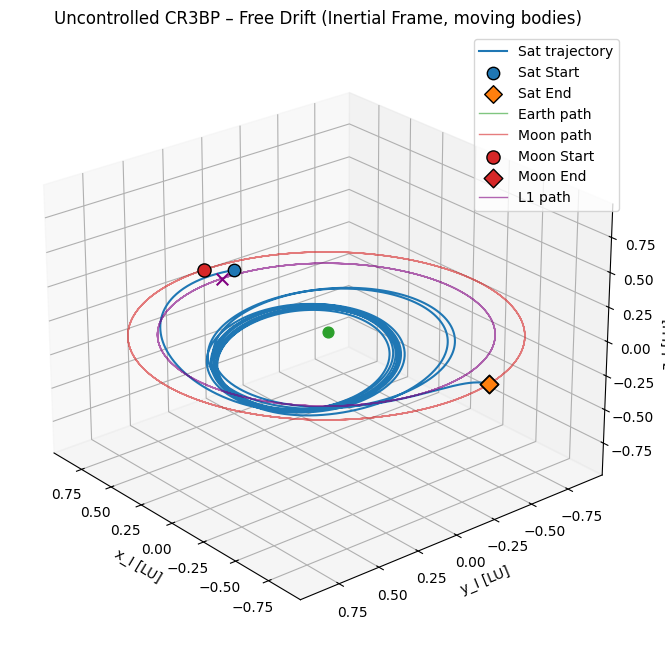

In [9]:
# ================================================================
# Cell 9 – Uncontrolled CR3BP free drift (inertial frame, moving primaries)
# ================================================================

# ---------------------------------------------------------------
# 1. Helper: rotating → inertial
# ---------------------------------------------------------------
def rotating_to_inertial(x, y, z, t):
    """
    Transform positions from the rotating (synodic) frame to the inertial frame.

    Rotation about the z-axis with angle θ = t.
    """
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    cos_t = np.cos(t)
    sin_t = np.sin(t)

    x_I = cos_t * x - sin_t * y
    y_I = sin_t * x + cos_t * y
    z_I = z
    return x_I, y_I, z_I

# ---------------------------------------------------------------
# 2. Data from free-drift rollout (previous cell)
# ---------------------------------------------------------------
pos_free_rot = rollout_free["pos_rot_abs"]   # (N, 3) in rotating frame
t_free = rollout_free["t"]                   # time stamps

xr, yr, zr = pos_free_rot[:, 0], pos_free_rot[:, 1], pos_free_rot[:, 2]
xI, yI, zI = rotating_to_inertial(xr, yr, zr, t_free)

N = len(t_free)
print(f"[INFO] Free-drift inertial plot, steps: {N}")

# ---------------------------------------------------------------
# 3. Earth, Moon, L1 in rotating frame (constant) → inertial paths
# ---------------------------------------------------------------
mu = SYSTEMS[scenario_cfg.system]["mu"]
earth_rot = np.array([-mu, 0.0, 0.0])
moon_rot = np.array([1.0 - mu, 0.0, 0.0])
L1_rot = np.asarray(env_free.lagrange_pos)

# Build constant position arrays over time in rotating frame
earth_x_r = np.full_like(t_free, earth_rot[0])
earth_y_r = np.full_like(t_free, earth_rot[1])
earth_z_r = np.full_like(t_free, earth_rot[2])

moon_x_r = np.full_like(t_free, moon_rot[0])
moon_y_r = np.full_like(t_free, moon_rot[1])
moon_z_r = np.full_like(t_free, moon_rot[2])

L1_x_r = np.full_like(t_free, L1_rot[0])
L1_y_r = np.full_like(t_free, L1_rot[1])
L1_z_r = np.full_like(t_free, L1_rot[2])

# Rotate all into the inertial frame
earth_x_I, earth_y_I, earth_z_I = rotating_to_inertial(earth_x_r, earth_y_r, earth_z_r, t_free)
moon_x_I, moon_y_I, moon_z_I = rotating_to_inertial(moon_x_r, moon_y_r, moon_z_r, t_free)
L1_x_I, L1_y_I, L1_z_I = rotating_to_inertial(L1_x_r, L1_y_r, L1_z_r, t_free)

# ---------------------------------------------------------------
# 4. Plot helpers
# ---------------------------------------------------------------
def set_equal_3d(ax, x, y, z):
    """Set equal scaling for all three axes in a 3D plot."""
    max_range = max(
        float(x.max() - x.min()),
        float(y.max() - y.min()),
        float(z.max() - z.min()),
    )
    mid_x = 0.5 * (float(x.max()) + float(x.min()))
    mid_y = 0.5 * (float(y.max()) + float(y.min()))
    mid_z = 0.5 * (float(z.max()) + float(z.min()))
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

def add_start_end_sat(ax, x, y, z, with_labels: bool = False):
    """Mark start and end of the satellite trajectory."""
    ax.scatter(
        [x[0]], [y[0]], [z[0]],
        s=80, marker="o",
        edgecolor="black", facecolor="tab:blue",
        linewidths=1.0,
        label="Sat Start" if with_labels else None,
        zorder=5,
    )
    ax.scatter(
        [x[-1]], [y[-1]], [z[-1]],
        s=80, marker="D",
        edgecolor="black", facecolor="tab:orange",
        linewidths=1.0,
        label="Sat End" if with_labels else None,
        zorder=5,
    )

def add_start_end_moon(ax, x, y, z, with_labels: bool = False):
    """Mark start and end of the Moon trajectory."""
    ax.scatter(
        [x[0]], [y[0]], [z[0]],
        s=90, marker="o",
        edgecolor="black", facecolor="tab:red",
        linewidths=1.0,
        label="Moon Start" if with_labels else None,
        zorder=5,
    )
    ax.scatter(
        [x[-1]], [y[-1]], [z[-1]],
        s=90, marker="D",
        edgecolor="black", facecolor="tab:red",
        linewidths=1.0,
        label="Moon End" if with_labels else None,
        zorder=5,
    )

# ---------------------------------------------------------------
# 5. Full-view inertial-frame plot (moving primaries)
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Satellite trajectory
ax.plot(xI, yI, zI, lw=1.5, color="tab:blue", label="Sat trajectory")
add_start_end_sat(ax, xI, yI, zI, with_labels=True)

# Earth path and marker
ax.plot(earth_x_I, earth_y_I, earth_z_I, lw=1.0, color="tab:green", alpha=0.6, label="Earth path")
ax.scatter([earth_x_I[0]], [earth_y_I[0]], [earth_z_I[0]], s=60, color="tab:green", zorder=4)

# Moon path and start/end
ax.plot(moon_x_I, moon_y_I, moon_z_I, lw=1.0, color="tab:red", alpha=0.6, label="Moon path")
add_start_end_moon(ax, moon_x_I, moon_y_I, moon_z_I, with_labels=True)

# L1 path and marker
ax.plot(L1_x_I, L1_y_I, L1_z_I, lw=1.0, color="purple", alpha=0.6, label="L1 path")
ax.scatter([L1_x_I[0]], [L1_y_I[0]], [L1_z_I[0]], s=70, color="purple", marker="x", zorder=4)

# Axis scaling and view
x_all = np.concatenate([xI, earth_x_I, moon_x_I, L1_x_I])
y_all = np.concatenate([yI, earth_y_I, moon_y_I, L1_y_I])
z_all = np.concatenate([zI, earth_z_I, moon_z_I, L1_z_I])
set_equal_3d(ax, x_all, y_all, z_all)

ax.set_xlabel("x_I [LU]")
ax.set_ylabel("y_I [LU]")
ax.set_zlabel("z_I [LU]")
ax.set_title("Uncontrolled CR3BP – Free Drift (Inertial Frame, moving bodies)")
ax.view_init(elev=25, azim=140)
ax.legend()
plt.show()


In [17]:
# ================================================================
# Cell 10 – Free drift animation (inertial frame, tail)
# ================================================================

# ---------------------------------------------------------------
# Settings
# ---------------------------------------------------------------
EXPORT_GIF = True
EXPORT_MP4 = False

FPS = 20
DPI = 100
TARGET_FRAMES = 800       # target number of frames after subsampling
TAIL_FRAMES = 80          # number of frames to keep in the visible tail

VIS_DIR = PROJECT_ROOT / "visualizations"
VIS_DIR.mkdir(parents=True, exist_ok=True)

GIF_PATH = VIS_DIR / "free_drift_inertial.gif"
MP4_PATH = VIS_DIR / "free_drift_inertial.mp4"

plt.rcParams["animation.embed_limit"] = 50  # in MB

# ---------------------------------------------------------------
# Helper: rotating → inertial
# ---------------------------------------------------------------
def rotating_to_inertial(x, y, z, t):
    """
    Transform positions from the rotating (synodic) frame to the inertial frame.

    Rotation about the z-axis with angle θ = t.
    """
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    cos_t = np.cos(t)
    sin_t = np.sin(t)

    x_I = cos_t * x - sin_t * y
    y_I = sin_t * x + cos_t * y
    z_I = z
    return x_I, y_I, z_I

# ---------------------------------------------------------------
# Trajectory data (free drift)
# ---------------------------------------------------------------
pos_free_rot = rollout_free["pos_rot_abs"]   # (N, 3) in rotating frame
t_free = rollout_free["t"]                   # time stamps

total_steps = len(pos_free_rot)
xr, yr, zr = pos_free_rot[:, 0], pos_free_rot[:, 1], pos_free_rot[:, 2]
xI, yI, zI = rotating_to_inertial(xr, yr, zr, t_free)

# Subsample to approximately TARGET_FRAMES
step = max(1, total_steps // TARGET_FRAMES)
frame_indices = np.arange(0, total_steps, step)
N = len(frame_indices)
print(f"[INFO] Free drift: total steps={total_steps}, using {N} frames (step={step})")

# ---------------------------------------------------------------
# Earth, Moon, L1 in inertial frame (co-rotating)
# ---------------------------------------------------------------
mu = SYSTEMS[scenario_cfg.system]["mu"]
earth_rot = np.array([-mu, 0.0, 0.0])
moon_rot = np.array([1.0 - mu, 0.0, 0.0])
L1_rot = np.asarray(env_free.lagrange_pos)

earth_x_r = np.full_like(t_free, earth_rot[0])
earth_y_r = np.full_like(t_free, earth_rot[1])
earth_z_r = np.full_like(t_free, earth_rot[2])

moon_x_r = np.full_like(t_free, moon_rot[0])
moon_y_r = np.full_like(t_free, moon_rot[1])
moon_z_r = np.full_like(t_free, moon_rot[2])

L1_x_r = np.full_like(t_free, L1_rot[0])
L1_y_r = np.full_like(t_free, L1_rot[1])
L1_z_r = np.full_like(t_free, L1_rot[2])

earth_x_I, earth_y_I, earth_z_I = rotating_to_inertial(earth_x_r, earth_y_r, earth_z_r, t_free)
moon_x_I, moon_y_I, moon_z_I = rotating_to_inertial(moon_x_r, moon_y_r, moon_z_r, t_free)
L1_x_I, L1_y_I, L1_z_I = rotating_to_inertial(L1_x_r, L1_y_r, L1_z_r, t_free)

# ---------------------------------------------------------------
# Figure setup (standard 3D view)
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("x_I [LU]")
ax.set_ylabel("y_I [LU]")
ax.set_zlabel("z_I [LU]")
ax.set_title("Uncontrolled CR3BP – Free Drift (Inertial Frame, Tail)")

def set_equal(ax, x, y, z):
    """Set equal scaling for all three axes."""
    max_range = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min())
    mx, my, mz = x.mean(), y.mean(), z.mean()
    ax.set_xlim(mx - max_range / 2, mx + max_range / 2)
    ax.set_ylim(my - max_range / 2, my + max_range / 2)
    ax.set_zlim(mz - max_range / 2, mz + max_range / 2)

x_all = np.concatenate([xI, earth_x_I, moon_x_I, L1_x_I])
y_all = np.concatenate([yI, earth_y_I, moon_y_I, L1_y_I])
z_all = np.concatenate([zI, earth_z_I, moon_z_I, L1_z_I])
set_equal(ax, x_all, y_all, z_all)

ax.view_init(elev=30, azim=135)

# ---------------------------------------------------------------
# Animated objects
# ---------------------------------------------------------------
# Satellite trajectory (tail)
line_sat, = ax.plot([], [], [], lw=2, color="tab:blue", label="Sat trajectory")

# Current satellite position
pt_sat, = ax.plot([], [], [], marker="o", color="tab:blue")

# Moving Earth/Moon/L1 markers
earth_pt, = ax.plot([], [], [], marker="o", color="tab:green", markersize=8, label="Earth")
moon_pt, = ax.plot([], [], [], marker="o", color="tab:red", markersize=6, label="Moon")
L1_pt, = ax.plot([], [], [], marker="x", color="purple", markersize=8, label="L1")

ax.legend()

# ---------------------------------------------------------------
# Animation functions
# ---------------------------------------------------------------
def init():
    """Initialize empty artists for the animation."""
    for obj in (line_sat, pt_sat, earth_pt, moon_pt, L1_pt):
        obj.set_data([], [])
        obj.set_3d_properties([])
    return line_sat, pt_sat, earth_pt, moon_pt, L1_pt

def update(frame_idx):
    """Update function for the inertial-frame tail animation."""
    i = frame_indices[frame_idx]

    # Tail window in frame indices
    start_frame = max(0, frame_idx - TAIL_FRAMES)
    tail_idx = frame_indices[start_frame:frame_idx + 1]

    # Satellite tail
    line_sat.set_data(xI[tail_idx], yI[tail_idx])
    line_sat.set_3d_properties(zI[tail_idx])

    # Current satellite point
    pt_sat.set_data([xI[i]], [yI[i]])
    pt_sat.set_3d_properties([zI[i]])

    # Earth, Moon, L1 positions in inertial frame at index i
    earth_pt.set_data([earth_x_I[i]], [earth_y_I[i]])
    earth_pt.set_3d_properties([earth_z_I[i]])

    moon_pt.set_data([moon_x_I[i]], [moon_y_I[i]])
    moon_pt.set_3d_properties([moon_z_I[i]])

    L1_pt.set_data([L1_x_I[i]], [L1_y_I[i]])
    L1_pt.set_3d_properties([L1_z_I[i]])

    return line_sat, pt_sat, earth_pt, moon_pt, L1_pt

ani = animation.FuncAnimation(
    fig,
    update,
    frames=N,
    init_func=init,
    interval=1000 / FPS,
    blit=True,
)

# ---------------------------------------------------------------
# Export
# ---------------------------------------------------------------
if EXPORT_GIF:
    print(f"[INFO] Exporting GIF to {GIF_PATH} ...")
    try:
        ani.save(str(GIF_PATH), writer="pillow", fps=FPS, dpi=DPI)
        print(f"[OK] Saved GIF → {GIF_PATH}")
    except Exception as e:
        print(f"[ERROR] GIF export failed: {e}")

if EXPORT_MP4:
    if animation.writers.is_available("ffmpeg"):
        print(f"[INFO] Exporting MP4 to {MP4_PATH} ...")
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=FPS, codec="h264", bitrate=1800)
            ani.save(str(MP4_PATH), writer=writer, dpi=DPI)
            print(f"[OK] Saved MP4 → {MP4_PATH}")
        except Exception as e:
            print(f"[ERROR] MP4 export failed: {e}")
    else:
        print("[WARN] ffmpeg not available in this environment – skipping MP4 export.")

# ---------------------------------------------------------------
# Show inside Jupyter
# ---------------------------------------------------------------
# HTML(ani.to_jshtml())  # enable this line to display the animation inline in Jupyter
plt.close('all')
None



[INFO] Free drift: total steps=2850, using 950 frames (step=3)
[INFO] Exporting GIF to c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\free_drift_inertial.gif ...
[OK] Saved GIF → c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\free_drift_inertial.gif


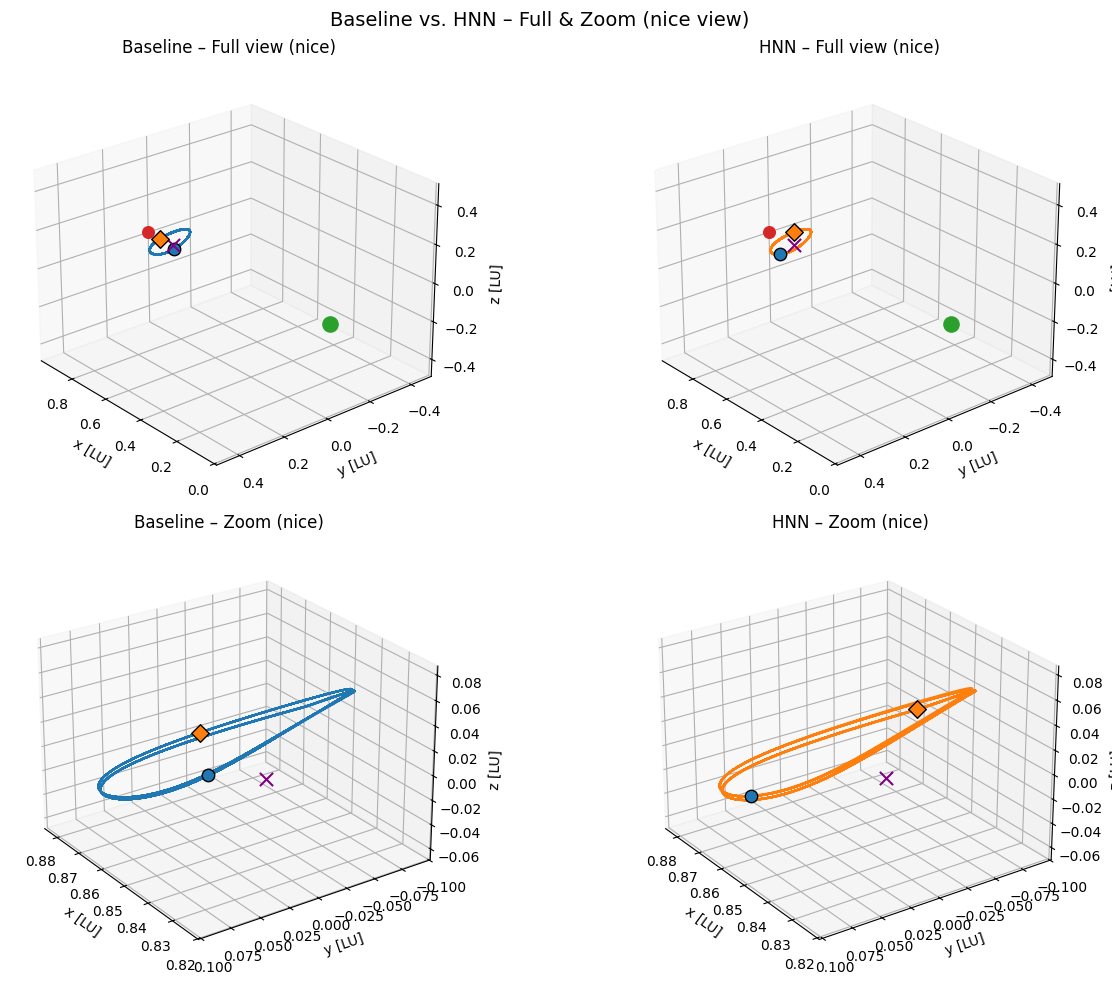

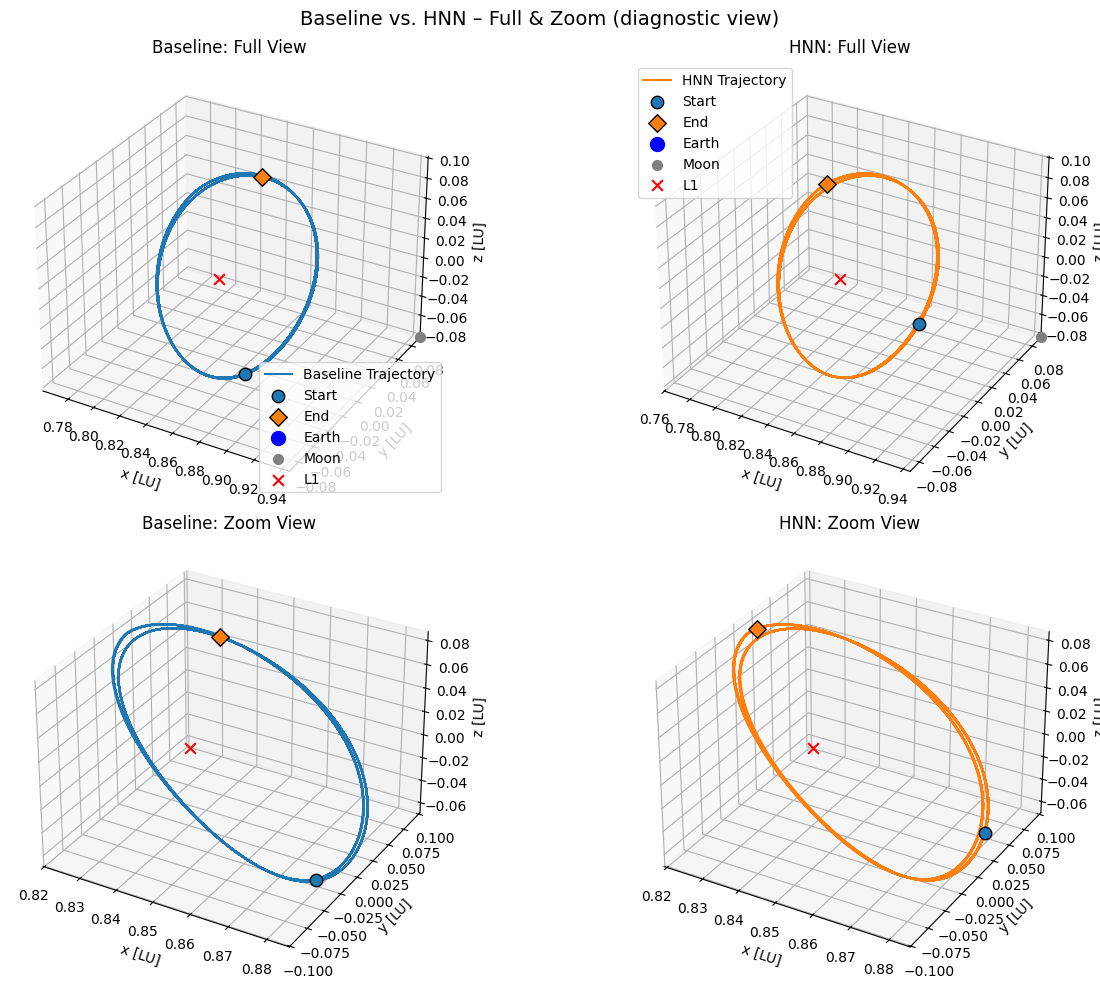

In [18]:
# ================================================================
# Cell 11 – Plotting: Baseline vs. HNN (2x2 grids)
# ================================================================

# Physics for plotting
mu = env_baseline.nominal_mu
primary1_pos = np.array([-mu, 0.0, 0.0])        # Earth
primary2_pos = np.array([1.0 - mu, 0.0, 0.0])   # Moon
L1_pos = np.asarray(env_baseline.lagrange_pos)  # L1 (3D)

def set_equal_3d(ax, x, y, z):
    """Set equal aspect ratio for 3D axes (based on given arrays)."""
    max_range = max(
        float(x.max() - x.min()),
        float(y.max() - y.min()),
        float(z.max() - z.min()),
    )
    mid_x = 0.5 * (float(x.max()) + float(x.min()))
    mid_y = 0.5 * (float(y.max()) + float(y.min()))
    mid_z = 0.5 * (float(z.max()) + float(z.min()))
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

def plot_trajectory_clean(ax, x, y, z, color, label=None):
    """Plot a trajectory and break the line at large jumps (glitch cleanup)."""
    points = np.column_stack((x, y, z))
    dists = np.linalg.norm(points[1:] - points[:-1], axis=1)

    threshold = 10.0 * np.median(dists)
    jump_indices = np.where(dists > threshold)[0]

    start_idx = 0
    for i, jump_idx in enumerate(jump_indices):
        end_idx = jump_idx + 1
        seg_label = label if (i == 0 and label is not None) else None
        ax.plot(
            x[start_idx:end_idx],
            y[start_idx:end_idx],
            z[start_idx:end_idx],
            lw=1.5,
            color=color,
            label=seg_label,
        )
        start_idx = end_idx

    seg_label = label if (len(jump_indices) == 0 and label is not None) else None
    ax.plot(
        x[start_idx:],
        y[start_idx:],
        z[start_idx:],
        lw=1.5,
        color=color,
        label=seg_label,
    )

def add_bodies(ax, with_labels: bool = False):
    """Add Earth, Moon, and L1 markers."""
    ax.scatter(
        [primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]],
        s=120, marker="o", color="tab:green",
        label="Earth" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]],
        s=70, marker="o", color="tab:red",
        label="Moon" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [L1_pos[0]], [L1_pos[1]], [L1_pos[2]],
        s=90, marker="x", color="purple",
        label="L1" if with_labels else None, zorder=4,
    )

def add_start_end_nice(ax, x, y, z, with_labels: bool = False):
    """Mark start and end of a trajectory with circle and diamond markers."""
    ax.scatter(
        [x[0]], [y[0]], [z[0]],
        s=80, marker="o",
        edgecolor="black", facecolor="tab:blue",
        linewidths=1.0,
        label="Start" if with_labels else None,
        zorder=5,
    )
    ax.scatter(
        [x[-1]], [y[-1]], [z[-1]],
        s=80, marker="D",
        edgecolor="black", facecolor="tab:orange",
        linewidths=1.0,
        label="End" if with_labels else None,
        zorder=5,
    )

def bounds_with_margin(arr, margin: float = 0.05):
    """Compute axis bounds with a relative margin around the data."""
    a_min, a_max = float(arr.min()), float(arr.max())
    span = a_max - a_min or 1e-3
    return a_min - margin * span, a_max + margin * span

# Prepare trajectory data
pos_b = rollout_base["pos_rot_abs"]
xb, yb, zb = pos_b[:, 0], pos_b[:, 1], pos_b[:, 2]

pos_h = rollout_hnn["pos_rot_abs"]
xh, yh, zh = pos_h[:, 0], pos_h[:, 1], pos_h[:, 2]

# ------------------------------------------------------------------
# FIGURE 1 – 2x2 with “nice” viewing angles
# ------------------------------------------------------------------
fig1 = plt.figure(figsize=(14, 10))
ax11 = fig1.add_subplot(2, 2, 1, projection="3d")  # Baseline full
ax12 = fig1.add_subplot(2, 2, 2, projection="3d")  # HNN full
ax13 = fig1.add_subplot(2, 2, 3, projection="3d")  # Baseline zoom
ax14 = fig1.add_subplot(2, 2, 4, projection="3d")  # HNN zoom

# 1) Baseline full (nice view)
plot_trajectory_clean(ax11, xb, yb, zb, color="tab:blue", label="Baseline")
add_start_end_nice(ax11, xb, yb, zb, with_labels=True)
add_bodies(ax11, with_labels=True)
x_all_b = np.concatenate([xb, [primary1_pos[0], primary2_pos[0], L1_pos[0]]])
y_all_b = np.concatenate([yb, [primary1_pos[1], primary2_pos[1], L1_pos[1]]])
z_all_b = np.concatenate([zb, [primary1_pos[2], primary2_pos[2], L1_pos[2]]])
set_equal_3d(ax11, x_all_b, y_all_b, z_all_b)
ax11.set_title("Baseline – Full view (nice)")
ax11.set_xlabel("x [LU]")
ax11.set_ylabel("y [LU]")
ax11.set_zlabel("z [LU]")
ax11.view_init(elev=25, azim=140)

# 2) HNN full (nice view)
plot_trajectory_clean(ax12, xh, yh, zh, color="tab:orange", label="HNN")
add_start_end_nice(ax12, xh, yh, zh, with_labels=False)
add_bodies(ax12, with_labels=False)
x_all_h = np.concatenate([xh, [primary1_pos[0], primary2_pos[0], L1_pos[0]]])
y_all_h = np.concatenate([yh, [primary1_pos[1], primary2_pos[1], L1_pos[1]]])
z_all_h = np.concatenate([zh, [primary1_pos[2], primary2_pos[2], L1_pos[2]]])
set_equal_3d(ax12, x_all_h, y_all_h, z_all_h)
ax12.set_title("HNN – Full view (nice)")
ax12.set_xlabel("x [LU]")
ax12.set_ylabel("y [LU]")
ax12.set_zlabel("z [LU]")
ax12.view_init(elev=25, azim=140)

# 3) Baseline zoom (nice view)
plot_trajectory_clean(ax13, xb, yb, zb, color="tab:blue")
add_start_end_nice(ax13, xb, yb, zb, with_labels=False)
add_bodies(ax13, with_labels=False)
x_min, x_max = bounds_with_margin(xb)
y_min, y_max = bounds_with_margin(yb)
z_min, z_max = bounds_with_margin(zb)
ax13.set_xlim(x_min, x_max)
ax13.set_ylim(y_min, y_max)
ax13.set_zlim(z_min, z_max)
ax13.set_title("Baseline – Zoom (nice)")
ax13.set_xlabel("x [LU]")
ax13.set_ylabel("y [LU]")
ax13.set_zlabel("z [LU]")
ax13.view_init(elev=25, azim=145)

# 4) HNN zoom (nice view)
plot_trajectory_clean(ax14, xh, yh, zh, color="tab:orange")
add_start_end_nice(ax14, xh, yh, zh, with_labels=False)
add_bodies(ax14, with_labels=False)
x_min, x_max = bounds_with_margin(xh)
y_min, y_max = bounds_with_margin(yh)
z_min, z_max = bounds_with_margin(zh)
ax14.set_xlim(x_min, x_max)
ax14.set_ylim(y_min, y_max)
ax14.set_zlim(z_min, z_max)
ax14.set_title("HNN – Zoom (nice)")
ax14.set_xlabel("x [LU]")
ax14.set_ylabel("y [LU]")
ax14.set_zlabel("z [LU]")
ax14.view_init(elev=25, azim=145)

fig1.suptitle("Baseline vs. HNN – Full & Zoom (nice view)", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# FIGURE 2 – 2x2 diagnostic view (same markers)
# ------------------------------------------------------------------
fig2 = plt.figure(figsize=(14, 10))
dx11 = fig2.add_subplot(2, 2, 1, projection="3d")
dx12 = fig2.add_subplot(2, 2, 2, projection="3d")
dx13 = fig2.add_subplot(2, 2, 3, projection="3d")
dx14 = fig2.add_subplot(2, 2, 4, projection="3d")

# Baseline full – diagnostic view
plot_trajectory_clean(dx11, xb, yb, zb, color="tab:blue", label="Baseline Trajectory")
add_start_end_nice(dx11, xb, yb, zb, with_labels=True)
dx11.scatter([primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]], color="blue", s=100, label="Earth")
dx11.scatter([primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]], color="gray", s=50, label="Moon")
dx11.scatter([L1_pos[0]], [L1_pos[1]], [L1_pos[2]], color="red", marker="x", s=60, label="L1")
dx11.set_xlabel("x [LU]")
dx11.set_ylabel("y [LU]")
dx11.set_zlabel("z [LU]")
dx11.set_title("Baseline: Full View")
set_equal_3d(dx11, xb, yb, zb)
dx11.legend()

# HNN full – diagnostic view
plot_trajectory_clean(dx12, xh, yh, zh, color="tab:orange", label="HNN Trajectory")
add_start_end_nice(dx12, xh, yh, zh, with_labels=True)
dx12.scatter([primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]], color="blue", s=100, label="Earth")
dx12.scatter([primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]], color="gray", s=50, label="Moon")
dx12.scatter([L1_pos[0]], [L1_pos[1]], [L1_pos[2]], color="red", marker="x", s=60, label="L1")
dx12.set_xlabel("x [LU]")
dx12.set_ylabel("y [LU]")
dx12.set_zlabel("z [LU]")
dx12.set_title("HNN: Full View")
set_equal_3d(dx12, xh, yh, zh)
dx12.legend()

# Baseline zoom – diagnostic view
plot_trajectory_clean(dx13, xb, yb, zb, color="tab:blue", label="Baseline Trajectory")
add_start_end_nice(dx13, xb, yb, zb, with_labels=False)
dx13.scatter([primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]], color="blue", s=100, label="Earth")
dx13.scatter([primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]], color="gray", s=50, label="Moon")
dx13.scatter([L1_pos[0]], [L1_pos[1]], [L1_pos[2]], color="red", marker="x", s=60, label="L1")
x_min, x_max = bounds_with_margin(xb, margin=0.05)
y_min, y_max = bounds_with_margin(yb, margin=0.05)
z_min, z_max = bounds_with_margin(zb, margin=0.05)
dx13.set_xlim(x_min, x_max)
dx13.set_ylim(y_min, y_max)
dx13.set_zlim(z_min, z_max)
dx13.set_xlabel("x [LU]")
dx13.set_ylabel("y [LU]")
dx13.set_zlabel("z [LU]")
dx13.set_title("Baseline: Zoom View")

# HNN zoom – diagnostic view
plot_trajectory_clean(dx14, xh, yh, zh, color="tab:orange", label="HNN Trajectory")
add_start_end_nice(dx14, xh, yh, zh, with_labels=False)
dx14.scatter([primary1_pos[0]], [primary1_pos[1]], [primary1_pos[2]], color="blue", s=100, label="Earth")
dx14.scatter([primary2_pos[0]], [primary2_pos[1]], [primary2_pos[2]], color="gray", s=50, label="Moon")
dx14.scatter([L1_pos[0]], [L1_pos[1]], [L1_pos[2]], color="red", marker="x", s=60, label="L1")
x_min, x_max = bounds_with_margin(xh, margin=0.05)
y_min, y_max = bounds_with_margin(yh, margin=0.05)
z_min, z_max = bounds_with_margin(zh, margin=0.05)
dx14.set_xlim(x_min, x_max)
dx14.set_ylim(y_min, y_max)
dx14.set_zlim(z_min, z_max)
dx14.set_xlabel("x [LU]")
dx14.set_ylabel("y [LU]")
dx14.set_zlabel("z [LU]")
dx14.set_title("HNN: Zoom View")

fig2.suptitle("Baseline vs. HNN – Full & Zoom (diagnostic view)", fontsize=14)
plt.tight_layout()
plt.show()


In [19]:
# ================================================================
# Cell 12 – 3D animation: Baseline vs. HNN (long cut, compact GIF)
# ================================================================

# ---------------------------------------------------------------
# Settings
# ---------------------------------------------------------------
EXPORT_GIF = True         # export GIF
EXPORT_MP4 = False        # export MP4 (requires working ffmpeg)

FPS = 20                  # lower FPS → smaller file size
DPI = 100                 # reasonable quality
TARGET_FRAMES = 1000      # target number of frames (subsampled)

VIS_DIR = PROJECT_ROOT / "visualizations"
VIS_DIR.mkdir(parents=True, exist_ok=True)

GIF_PATH = VIS_DIR / "baseline_vs_hnn.gif"
MP4_PATH = VIS_DIR / "baseline_vs_hnn.mp4"

plt.rcParams["animation.embed_limit"] = 50  # in MB

# ---------------------------------------------------------------
# Trajectory data
# ---------------------------------------------------------------
pos_b = rollout_base["pos_rot_abs"]
pos_h = rollout_hnn["pos_rot_abs"]

xb, yb, zb = pos_b[:, 0], pos_b[:, 1], pos_b[:, 2]
xh, yh, zh = pos_h[:, 0], pos_h[:, 1], pos_h[:, 2]

total_steps = min(len(xb), len(xh))

# Choose step so that we use at most ~TARGET_FRAMES frames
step = max(1, total_steps // TARGET_FRAMES)
frame_indices = np.arange(0, total_steps, step)
N = len(frame_indices)

print(f"[INFO] Total steps: {total_steps}, using {N} frames (step={step})")

# ---------------------------------------------------------------
# Physics markers
# ---------------------------------------------------------------
mu = env_baseline.nominal_mu
earth = np.array([-mu, 0.0, 0.0])
moon = np.array([1.0 - mu, 0.0, 0.0])
L1 = np.asarray(env_baseline.lagrange_pos)

# ---------------------------------------------------------------
# Figure setup
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("x [LU]")
ax.set_ylabel("y [LU]")
ax.set_zlabel("z [LU]")
ax.set_title("Baseline vs. HNN – 3D trajectory animation")

# Equal scaling based on both trajectories
x_all = np.concatenate([xb, xh])
y_all = np.concatenate([yb, yh])
z_all = np.concatenate([zb, zh])

def set_equal(ax, x, y, z):
    """Set equal scaling for all three axes."""
    max_range = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min())
    mx, my, mz = x.mean(), y.mean(), z.mean()
    ax.set_xlim(mx - max_range / 2, mx + max_range / 2)
    ax.set_ylim(my - max_range / 2, my + max_range / 2)
    ax.set_zlim(mz - max_range / 2, mz + max_range / 2)

set_equal(ax, x_all, y_all, z_all)
ax.view_init(elev=30, azim=135)

# ---------------------------------------------------------------
# Static bodies
# ---------------------------------------------------------------
ax.scatter(*earth, s=120, label="Earth", color="tab:green")
ax.scatter(*moon,  s=70,  label="Moon",  color="tab:red")
ax.scatter(*L1,    s=90,  label="L1",    color="purple", marker="x")

# ---------------------------------------------------------------
# Animated objects
# ---------------------------------------------------------------
line_b, = ax.plot([], [], [], lw=2, color="tab:blue", label="Baseline")
line_h, = ax.plot([], [], [], lw=2, color="tab:orange", label="HNN")

pt_b, = ax.plot([], [], [], marker="o", color="tab:blue")
pt_h, = ax.plot([], [], [], marker="D", color="tab:orange")

ax.legend()

# ---------------------------------------------------------------
# Animation functions
# ---------------------------------------------------------------
def init():
    """Initialize empty artists for the animation."""
    line_b.set_data([], [])
    line_b.set_3d_properties([])

    line_h.set_data([], [])
    line_h.set_3d_properties([])

    pt_b.set_data([], [])
    pt_b.set_3d_properties([])

    pt_h.set_data([], [])
    pt_h.set_3d_properties([])

    return line_b, line_h, pt_b, pt_h

def update(frame_idx):
    """Update function for the baseline vs. HNN trajectory animation."""
    i = frame_indices[frame_idx]

    # Baseline trajectory up to frame i
    line_b.set_data(xb[:i + 1], yb[:i + 1])
    line_b.set_3d_properties(zb[:i + 1])

    # HNN trajectory up to frame i
    line_h.set_data(xh[:i + 1], yh[:i + 1])
    line_h.set_3d_properties(zh[:i + 1])

    # Current points
    pt_b.set_data([xb[i]], [yb[i]])
    pt_b.set_3d_properties([zb[i]])

    pt_h.set_data([xh[i]], [yh[i]])
    pt_h.set_3d_properties([zh[i]])

    return line_b, line_h, pt_b, pt_h

ani = animation.FuncAnimation(
    fig,
    update,
    frames=N,
    init_func=init,
    interval=1000 / FPS,
    blit=True,
)

# ---------------------------------------------------------------
# Export
# ---------------------------------------------------------------
if EXPORT_GIF:
    print(f"[INFO] Exporting GIF to {GIF_PATH} ...")
    ani.save(str(GIF_PATH), writer="pillow", fps=FPS, dpi=DPI)
    print(f"[OK] Saved GIF → {GIF_PATH}")

if EXPORT_MP4:
    print(f"[INFO] Exporting MP4 to {MP4_PATH} ...")
    try:
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=FPS, codec="h264", bitrate=1800)
        ani.save(str(MP4_PATH), writer=writer, dpi=DPI)
        print(f"[OK] Saved MP4 → {MP4_PATH}")
    except Exception as e:
        print(f"[ERROR] MP4 export failed: {e}")

# ---------------------------------------------------------------
# Show inside Jupyter
# ---------------------------------------------------------------
# HTML(ani.to_jshtml())  # enable this line to display the animation inline in Jupyter

plt.close(fig)
None


[INFO] Total steps: 6000, using 1000 frames (step=6)
[INFO] Exporting GIF to c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn.gif ...
[OK] Saved GIF → c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn.gif


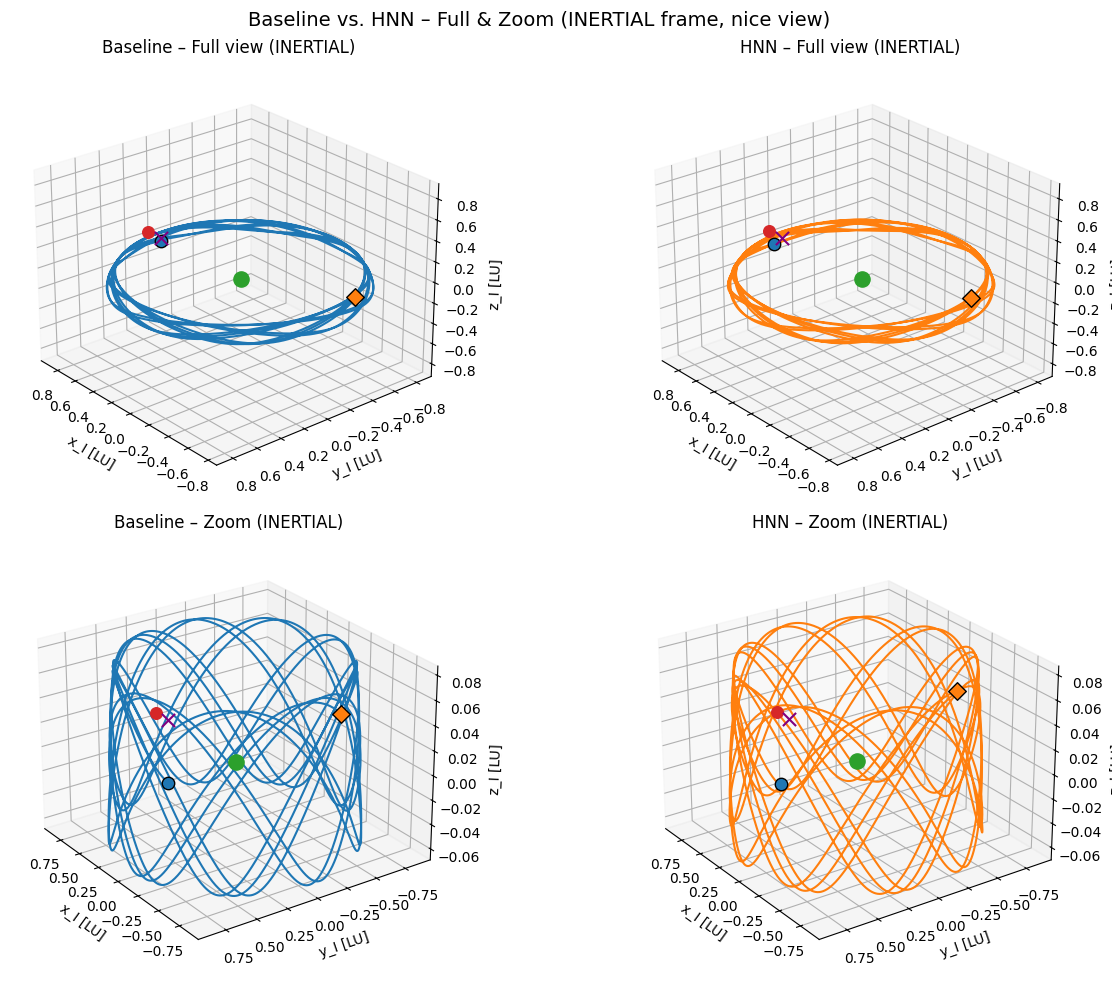

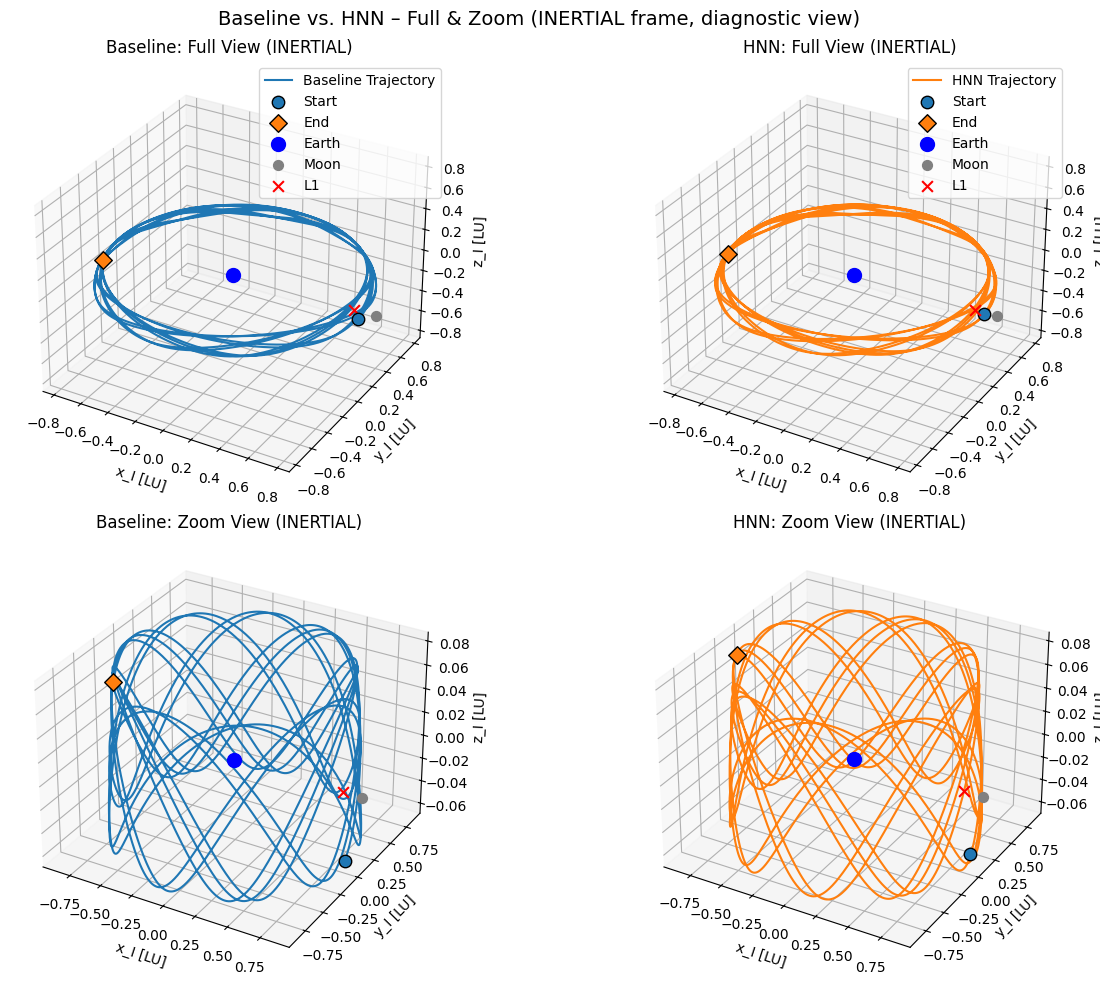

In [20]:
# ================================================================
# Cell 13 – Plotting in INERTIAL frame (2x2 grids)
# ================================================================

# ------------------------------------------------------------------
# Helper: rotating → inertial transform
# ------------------------------------------------------------------
def rotating_to_inertial(x, y, z, t):
    """
    Transform positions from the rotating (synodic) frame to the inertial frame
    using a rotation about the z-axis with angle θ = t
    (CR3BP normalized mean motion n = 1).
    """
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    cos_t = np.cos(t)
    sin_t = np.sin(t)

    x_I = cos_t * x - sin_t * y
    y_I = sin_t * x + cos_t * y
    z_I = z  # rotation around z-axis, z-component unchanged
    return x_I, y_I, z_I

# ------------------------------------------------------------------
# Physics for plotting (barycentric positions at t = 0)
# ------------------------------------------------------------------
mu = env_baseline.nominal_mu
primary1_pos_rot = np.array([-mu, 0.0, 0.0])        # Earth in rotating frame
primary2_pos_rot = np.array([1.0 - mu, 0.0, 0.0])   # Moon in rotating frame
L1_pos_rot       = np.asarray(env_baseline.lagrange_pos)  # L1 in rotating frame

# For t = 0, rotating frame = inertial frame
primary1_pos_I = primary1_pos_rot.copy()
primary2_pos_I = primary2_pos_rot.copy()
L1_pos_I       = L1_pos_rot.copy()

# ------------------------------------------------------------------
# Helpers (same logic as in Cell 11)
# ------------------------------------------------------------------
def set_equal_3d(ax, x, y, z):
    """Set equal aspect ratio for 3D axes (based on given arrays)."""
    max_range = max(
        float(x.max() - x.min()),
        float(y.max() - y.min()),
        float(z.max() - z.min()),
    )
    mid_x = 0.5 * (float(x.max()) + float(x.min()))
    mid_y = 0.5 * (float(y.max()) + float(y.min()))
    mid_z = 0.5 * (float(z.max()) + float(z.min()))
    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

def plot_trajectory_clean(ax, x, y, z, color, label=None):
    """Plot a trajectory and break the line at large jumps (glitch cleanup)."""
    points = np.column_stack((x, y, z))
    dists = np.linalg.norm(points[1:] - points[:-1], axis=1)

    threshold = 10.0 * np.median(dists)
    jump_indices = np.where(dists > threshold)[0]

    start_idx = 0
    for i, jump_idx in enumerate(jump_indices):
        end_idx = jump_idx + 1
        seg_label = label if (i == 0 and label is not None) else None
        ax.plot(
            x[start_idx:end_idx],
            y[start_idx:end_idx],
            z[start_idx:end_idx],
            lw=1.5,
            color=color,
            label=seg_label,
        )
        start_idx = end_idx

    seg_label = label if (len(jump_indices) == 0 and label is not None) else None
    ax.plot(
        x[start_idx:],
        y[start_idx:],
        z[start_idx:],
        lw=1.5,
        color=color,
        label=seg_label,
    )

def add_bodies_inertial(ax, with_labels: bool = False):
    """Add Earth, Moon, and L1 markers in the inertial frame at t = 0."""
    ax.scatter(
        [primary1_pos_I[0]], [primary1_pos_I[1]], [primary1_pos_I[2]],
        s=120, marker="o", color="tab:green",
        label="Earth" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [primary2_pos_I[0]], [primary2_pos_I[1]], [primary2_pos_I[2]],
        s=70, marker="o", color="tab:red",
        label="Moon" if with_labels else None, zorder=4,
    )
    ax.scatter(
        [L1_pos_I[0]], [L1_pos_I[1]], [L1_pos_I[2]],
        s=90, marker="x", color="purple",
        label="L1" if with_labels else None, zorder=4,
    )

def add_start_end_nice(ax, x, y, z, with_labels: bool = False):
    """Mark start and end of a trajectory with circle and diamond markers."""
    ax.scatter(
        [x[0]], [y[0]], [z[0]],
        s=80, marker="o",
        edgecolor="black", facecolor="tab:blue",
        linewidths=1.0,
        label="Start" if with_labels else None,
        zorder=5,
    )
    ax.scatter(
        [x[-1]], [y[-1]], [z[-1]],
        s=80, marker="D",
        edgecolor="black", facecolor="tab:orange",
        linewidths=1.0,
        label="End" if with_labels else None,
        zorder=5,
    )

def bounds_with_margin(arr, margin: float = 0.05):
    """Compute axis bounds with a relative margin around the data."""
    a_min, a_max = float(arr.min()), float(arr.max())
    span = a_max - a_min or 1e-3
    return a_min - margin * span, a_max + margin * span

# ------------------------------------------------------------------
# Rollout data + transformation to inertial frame
# ------------------------------------------------------------------
# Baseline
pos_b_rot = rollout_base["pos_rot_abs"]
t_b       = rollout_base["t"]
xb_r, yb_r, zb_r = pos_b_rot[:, 0], pos_b_rot[:, 1], pos_b_rot[:, 2]
xb_I, yb_I, zb_I = rotating_to_inertial(xb_r, yb_r, zb_r, t_b)

# HNN
pos_h_rot = rollout_hnn["pos_rot_abs"]
t_h       = rollout_hnn["t"]
xh_r, yh_r, zh_r = pos_h_rot[:, 0], pos_h_rot[:, 1], pos_h_rot[:, 2]
xh_I, yh_I, zh_I = rotating_to_inertial(xh_r, yh_r, zh_r, t_h)

# ------------------------------------------------------------------
# FIGURE 1 – 2x2 with "nice" viewing angles (INERTIAL)
# ------------------------------------------------------------------
fig1 = plt.figure(figsize=(14, 10))
ax11 = fig1.add_subplot(2, 2, 1, projection="3d")  # Baseline full
ax12 = fig1.add_subplot(2, 2, 2, projection="3d")  # HNN full
ax13 = fig1.add_subplot(2, 2, 3, projection="3d")  # Baseline zoom
ax14 = fig1.add_subplot(2, 2, 4, projection="3d")  # HNN zoom

# 1) Baseline full (nice view, inertial)
plot_trajectory_clean(ax11, xb_I, yb_I, zb_I, color="tab:blue", label="Baseline")
add_start_end_nice(ax11, xb_I, yb_I, zb_I, with_labels=True)
add_bodies_inertial(ax11, with_labels=True)
x_all_b = np.concatenate([xb_I, [primary1_pos_I[0], primary2_pos_I[0], L1_pos_I[0]]])
y_all_b = np.concatenate([yb_I, [primary1_pos_I[1], primary2_pos_I[1], L1_pos_I[1]]])
z_all_b = np.concatenate([zb_I, [primary1_pos_I[2], primary2_pos_I[2], L1_pos_I[2]]])
set_equal_3d(ax11, x_all_b, y_all_b, z_all_b)
ax11.set_title("Baseline – Full view (INERTIAL)")
ax11.set_xlabel("x_I [LU]")
ax11.set_ylabel("y_I [LU]")
ax11.set_zlabel("z_I [LU]")
ax11.view_init(elev=25, azim=140)

# 2) HNN full (nice view, inertial)
plot_trajectory_clean(ax12, xh_I, yh_I, zh_I, color="tab:orange", label="HNN")
add_start_end_nice(ax12, xh_I, yh_I, zh_I, with_labels=False)
add_bodies_inertial(ax12, with_labels=False)
x_all_h = np.concatenate([xh_I, [primary1_pos_I[0], primary2_pos_I[0], L1_pos_I[0]]])
y_all_h = np.concatenate([yh_I, [primary1_pos_I[1], primary2_pos_I[1], L1_pos_I[1]]])
z_all_h = np.concatenate([zh_I, [primary1_pos_I[2], primary2_pos_I[2], L1_pos_I[2]]])
set_equal_3d(ax12, x_all_h, y_all_h, z_all_h)
ax12.set_title("HNN – Full view (INERTIAL)")
ax12.set_xlabel("x_I [LU]")
ax12.set_ylabel("y_I [LU]")
ax12.set_zlabel("z_I [LU]")
ax12.view_init(elev=25, azim=140)

# 3) Baseline zoom (nice view, inertial)
plot_trajectory_clean(ax13, xb_I, yb_I, zb_I, color="tab:blue")
add_start_end_nice(ax13, xb_I, yb_I, zb_I, with_labels=False)
add_bodies_inertial(ax13, with_labels=False)
x_min, x_max = bounds_with_margin(xb_I)
y_min, y_max = bounds_with_margin(yb_I)
z_min, z_max = bounds_with_margin(zb_I)
ax13.set_xlim(x_min, x_max)
ax13.set_ylim(y_min, y_max)
ax13.set_zlim(z_min, z_max)
ax13.set_title("Baseline – Zoom (INERTIAL)")
ax13.set_xlabel("x_I [LU]")
ax13.set_ylabel("y_I [LU]")
ax13.set_zlabel("z_I [LU]")
ax13.view_init(elev=25, azim=145)

# 4) HNN zoom (nice view, inertial)
plot_trajectory_clean(ax14, xh_I, yh_I, zh_I, color="tab:orange")
add_start_end_nice(ax14, xh_I, yh_I, zh_I, with_labels=False)
add_bodies_inertial(ax14, with_labels=False)
x_min, x_max = bounds_with_margin(xh_I)
y_min, y_max = bounds_with_margin(yh_I)
z_min, z_max = bounds_with_margin(zh_I)
ax14.set_xlim(x_min, x_max)
ax14.set_ylim(y_min, y_max)
ax14.set_zlim(z_min, z_max)
ax14.set_title("HNN – Zoom (INERTIAL)")
ax14.set_xlabel("x_I [LU]")
ax14.set_ylabel("y_I [LU]")
ax14.set_zlabel("z_I [LU]")
ax14.view_init(elev=25, azim=145)

fig1.suptitle("Baseline vs. HNN – Full & Zoom (INERTIAL frame, nice view)", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# FIGURE 2 – 2x2 diagnostic view (INERTIAL, same markers)
# ------------------------------------------------------------------
fig2 = plt.figure(figsize=(14, 10))
dx11 = fig2.add_subplot(2, 2, 1, projection="3d")
dx12 = fig2.add_subplot(2, 2, 2, projection="3d")
dx13 = fig2.add_subplot(2, 2, 3, projection="3d")
dx14 = fig2.add_subplot(2, 2, 4, projection="3d")

# Baseline full – diagnostic (INERTIAL)
plot_trajectory_clean(dx11, xb_I, yb_I, zb_I, color="tab:blue", label="Baseline Trajectory")
add_start_end_nice(dx11, xb_I, yb_I, zb_I, with_labels=True)
dx11.scatter([primary1_pos_I[0]], [primary1_pos_I[1]], [primary1_pos_I[2]], color="blue", s=100, label="Earth")
dx11.scatter([primary2_pos_I[0]], [primary2_pos_I[1]], [primary2_pos_I[2]], color="gray", s=50, label="Moon")
dx11.scatter([L1_pos_I[0]], [L1_pos_I[1]], [L1_pos_I[2]], color="red", marker="x", s=60, label="L1")
dx11.set_xlabel("x_I [LU]")
dx11.set_ylabel("y_I [LU]")
dx11.set_zlabel("z_I [LU]")
dx11.set_title("Baseline: Full View (INERTIAL)")
set_equal_3d(dx11, xb_I, yb_I, zb_I)
dx11.legend()

# HNN full – diagnostic (INERTIAL)
plot_trajectory_clean(dx12, xh_I, yh_I, zh_I, color="tab:orange", label="HNN Trajectory")
add_start_end_nice(dx12, xh_I, yh_I, zh_I, with_labels=True)
dx12.scatter([primary1_pos_I[0]], [primary1_pos_I[1]], [primary1_pos_I[2]], color="blue", s=100, label="Earth")
dx12.scatter([primary2_pos_I[0]], [primary2_pos_I[1]], [primary2_pos_I[2]], color="gray", s=50, label="Moon")
dx12.scatter([L1_pos_I[0]], [L1_pos_I[1]], [L1_pos_I[2]], color="red", marker="x", s=60, label="L1")
dx12.set_xlabel("x_I [LU]")
dx12.set_ylabel("y_I [LU]")
dx12.set_zlabel("z_I [LU]")
dx12.set_title("HNN: Full View (INERTIAL)")
set_equal_3d(dx12, xh_I, yh_I, zh_I)
dx12.legend()

# Baseline zoom – diagnostic (INERTIAL)
plot_trajectory_clean(dx13, xb_I, yb_I, zb_I, color="tab:blue", label="Baseline Trajectory")
add_start_end_nice(dx13, xb_I, yb_I, zb_I, with_labels=False)
dx13.scatter([primary1_pos_I[0]], [primary1_pos_I[1]], [primary1_pos_I[2]], color="blue", s=100, label="Earth")
dx13.scatter([primary2_pos_I[0]], [primary2_pos_I[1]], [primary2_pos_I[2]], color="gray", s=50, label="Moon")
dx13.scatter([L1_pos_I[0]], [L1_pos_I[1]], [L1_pos_I[2]], color="red", marker="x", s=60, label="L1")
x_min, x_max = bounds_with_margin(xb_I, margin=0.05)
y_min, y_max = bounds_with_margin(yb_I, margin=0.05)
z_min, z_max = bounds_with_margin(zb_I, margin=0.05)
dx13.set_xlim(x_min, x_max)
dx13.set_ylim(y_min, y_max)
dx13.set_zlim(z_min, z_max)
dx13.set_xlabel("x_I [LU]")
dx13.set_ylabel("y_I [LU]")
dx13.set_zlabel("z_I [LU]")
dx13.set_title("Baseline: Zoom View (INERTIAL)")

# HNN zoom – diagnostic (INERTIAL)
plot_trajectory_clean(dx14, xh_I, yh_I, zh_I, color="tab:orange", label="HNN Trajectory")
add_start_end_nice(dx14, xh_I, yh_I, zh_I, with_labels=False)
dx14.scatter([primary1_pos_I[0]], [primary1_pos_I[1]], [primary1_pos_I[2]], color="blue", s=100, label="Earth")
dx14.scatter([primary2_pos_I[0]], [primary2_pos_I[1]], [primary2_pos_I[2]], color="gray", s=50, label="Moon")
dx14.scatter([L1_pos_I[0]], [L1_pos_I[1]], [L1_pos_I[2]], color="red", marker="x", s=60, label="L1")
x_min, x_max = bounds_with_margin(xh_I, margin=0.05)
y_min, y_max = bounds_with_margin(yh_I, margin=0.05)
z_min, z_max = bounds_with_margin(zh_I, margin=0.05)
dx14.set_xlim(x_min, x_max)
dx14.set_ylim(y_min, y_max)
dx14.set_zlim(z_min, z_max)
dx14.set_xlabel("x_I [LU]")
dx14.set_ylabel("y_I [LU]")
dx14.set_zlabel("z_I [LU]")
dx14.set_title("HNN: Zoom View (INERTIAL)")

fig2.suptitle("Baseline vs. HNN – Full & Zoom (INERTIAL frame, diagnostic view)", fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
# ================================================================
# Cell 14 – 3D animation (INERTIAL, normal view, tail)
# ================================================================

# ---------------------------------------------------------------
# Settings
# ---------------------------------------------------------------
EXPORT_GIF = True
EXPORT_MP4 = False

FPS = 20
DPI = 100
TARGET_FRAMES = 1000      # target number of frames after subsampling
TAIL_FRAMES = 80          # number of frames kept in the visible tail

VIS_DIR = PROJECT_ROOT / "visualizations"
VIS_DIR.mkdir(parents=True, exist_ok=True)

GIF_PATH = VIS_DIR / "baseline_vs_hnn_inertial_full.gif"
MP4_PATH = VIS_DIR / "baseline_vs_hnn_inertial_full.mp4"

plt.rcParams["animation.embed_limit"] = 50  # in MB

# ---------------------------------------------------------------
# Helper: rotating → inertial
# ---------------------------------------------------------------
def rotating_to_inertial(x, y, z, t):
    """
    Transform positions from the rotating (synodic) frame to the inertial frame.

    Rotation about the z-axis with angle θ = t.
    """
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    cos_t = np.cos(t)
    sin_t = np.sin(t)

    x_I = cos_t * x - sin_t * y
    y_I = sin_t * x + cos_t * y
    z_I = z
    return x_I, y_I, z_I

# ---------------------------------------------------------------
# Trajectory data (rotating → inertial)
# ---------------------------------------------------------------
pos_b_rot = rollout_base["pos_rot_abs"]
t_b       = rollout_base["t"]

pos_h_rot = rollout_hnn["pos_rot_abs"]
t_h       = rollout_hnn["t"]

# enforce same length for both rollouts
total_steps = min(len(pos_b_rot), len(pos_h_rot))
pos_b_rot = pos_b_rot[:total_steps]
pos_h_rot = pos_h_rot[:total_steps]
t_b = t_b[:total_steps]
t_h = t_h[:total_steps]

xb_r, yb_r, zb_r = pos_b_rot[:, 0], pos_b_rot[:, 1], pos_b_rot[:, 2]
xh_r, yh_r, zh_r = pos_h_rot[:, 0], pos_h_rot[:, 1], pos_h_rot[:, 2]

xb_I, yb_I, zb_I = rotating_to_inertial(xb_r, yb_r, zb_r, t_b)
xh_I, yh_I, zh_I = rotating_to_inertial(xh_r, yh_r, zh_r, t_h)

# Subsample to approximately TARGET_FRAMES
step = max(1, total_steps // TARGET_FRAMES)
frame_indices = np.arange(0, total_steps, step)
N = len(frame_indices)
print(f"[INFO] Total steps: {total_steps}, using {N} frames (step={step})")

# ---------------------------------------------------------------
# Earth, Moon, L1 in inertial frame (co-rotating)
# ---------------------------------------------------------------
mu = env_baseline.nominal_mu
earth_rot = np.array([-mu, 0.0, 0.0])
moon_rot  = np.array([1.0 - mu, 0.0, 0.0])
L1_rot    = np.asarray(env_baseline.lagrange_pos)

earth_x_I, earth_y_I, earth_z_I = rotating_to_inertial(
    np.full_like(t_b, earth_rot[0]),
    np.full_like(t_b, earth_rot[1]),
    np.full_like(t_b, earth_rot[2]),
    t_b,
)
moon_x_I, moon_y_I, moon_z_I = rotating_to_inertial(
    np.full_like(t_b, moon_rot[0]),
    np.full_like(t_b, moon_rot[1]),
    np.full_like(t_b, moon_rot[2]),
    t_b,
)
L1_x_I, L1_y_I, L1_z_I = rotating_to_inertial(
    np.full_like(t_b, L1_rot[0]),
    np.full_like(t_b, L1_rot[1]),
    np.full_like(t_b, L1_rot[2]),
    t_b,
)

# ---------------------------------------------------------------
# Figure setup (normal view)
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("x_I [LU]")
ax.set_ylabel("y_I [LU]")
ax.set_zlabel("z_I [LU]")
ax.set_title("Baseline vs. HNN – Inertial frame (normal view, tail)")

def set_equal(ax, x, y, z):
    """Set equal scaling for all three axes."""
    max_range = max(x.max() - x.min(), y.max() - y.min(), z.max() - z.min())
    mx, my, mz = x.mean(), y.mean(), z.mean()
    ax.set_xlim(mx - max_range / 2, mx + max_range / 2)
    ax.set_ylim(my - max_range / 2, my + max_range / 2)
    ax.set_zlim(mz - max_range / 2, mz + max_range / 2)

x_all = np.concatenate([xb_I, xh_I, earth_x_I, moon_x_I])
y_all = np.concatenate([yb_I, yh_I, earth_y_I, moon_y_I])
z_all = np.concatenate([zb_I, zh_I, earth_z_I, moon_z_I])
set_equal(ax, x_all, y_all, z_all)

ax.view_init(elev=30, azim=135)

# ---------------------------------------------------------------
# Animated objects
# ---------------------------------------------------------------
# Trajectories (tail)
line_b, = ax.plot([], [], [], lw=2, color="tab:blue", label="Baseline")
line_h, = ax.plot([], [], [], lw=2, color="tab:orange", label="HNN")

# Current points
pt_b, = ax.plot([], [], [], marker="o", color="tab:blue")
pt_h, = ax.plot([], [], [], marker="D", color="tab:orange")

# Moving Earth/Moon/L1
earth_pt, = ax.plot([], [], [], marker="o", color="tab:green",  markersize=8, label="Earth")
moon_pt,  = ax.plot([], [], [], marker="o", color="tab:red",    markersize=6, label="Moon")
L1_pt,    = ax.plot([], [], [], marker="x", color="purple",     markersize=8, label="L1")

ax.legend()

# ---------------------------------------------------------------
# Animation functions
# ---------------------------------------------------------------
def init():
    """Initialize all animated artists as empty."""
    for obj in (line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt):
        obj.set_data([], [])
        obj.set_3d_properties([])
    return line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt

def update(frame_idx):
    """Update function for the inertial-frame tail animation."""
    i = frame_indices[frame_idx]

    # Tail window in frame indices
    start_frame = max(0, frame_idx - TAIL_FRAMES)
    tail_idx = frame_indices[start_frame:frame_idx + 1]

    # Baseline tail
    line_b.set_data(xb_I[tail_idx], yb_I[tail_idx])
    line_b.set_3d_properties(zb_I[tail_idx])

    # HNN tail
    line_h.set_data(xh_I[tail_idx], yh_I[tail_idx])
    line_h.set_3d_properties(zh_I[tail_idx])

    # Current points
    pt_b.set_data([xb_I[i]], [yb_I[i]])
    pt_b.set_3d_properties([zb_I[i]])

    pt_h.set_data([xh_I[i]], [yh_I[i]])
    pt_h.set_3d_properties([zh_I[i]])

    # Earth, Moon, L1 in inertial frame at index i
    earth_pt.set_data([earth_x_I[i]], [earth_y_I[i]])
    earth_pt.set_3d_properties([earth_z_I[i]])

    moon_pt.set_data([moon_x_I[i]], [moon_y_I[i]])
    moon_pt.set_3d_properties([moon_z_I[i]])

    L1_pt.set_data([L1_x_I[i]], [L1_y_I[i]])
    L1_pt.set_3d_properties([L1_z_I[i]])

    return line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt

ani = animation.FuncAnimation(
    fig,
    update,
    frames=N,
    init_func=init,
    interval=1000 / FPS,
    blit=True,
)

# ---------------------------------------------------------------
# Export
# ---------------------------------------------------------------
if EXPORT_GIF:
    print(f"[INFO] Exporting GIF to {GIF_PATH} ...")
    ani.save(str(GIF_PATH), writer="pillow", fps=FPS, dpi=DPI)
    print(f"[OK] Saved GIF → {GIF_PATH}")

if EXPORT_MP4:
    print(f"[INFO] Exporting MP4 to {MP4_PATH} ...")
    try:
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=FPS, codec="h264", bitrate=1800)
        ani.save(str(MP4_PATH), writer=writer, dpi=DPI)
        print(f"[OK] Saved MP4 → {MP4_PATH}")
    except Exception as e:
        print(f"[ERROR] MP4 export failed: {e}")

# ---------------------------------------------------------------
# Show inside Jupyter
# ---------------------------------------------------------------
# HTML(ani.to_jshtml())  # enable this line to display the animation inline in Jupyter

plt.close(fig)
None


[INFO] Total steps: 6000, using 1000 frames (step=6)
[INFO] Exporting GIF to c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn_inertial_full.gif ...
[OK] Saved GIF → c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn_inertial_full.gif


In [22]:
# ================================================================
# Cell 15 – 3D animation (INERTIAL, zoom view, tail)
# ================================================================

# ---------------------------------------------------------------
# Settings
# ---------------------------------------------------------------
EXPORT_GIF = True
EXPORT_MP4 = False  # keep MP4 path/logic but disabled for now

FPS = 20
DPI = 100
TARGET_FRAMES = 1000
TAIL_FRAMES = 80

VIS_DIR = PROJECT_ROOT / "visualizations"
VIS_DIR.mkdir(parents=True, exist_ok=True)

GIF_PATH = VIS_DIR / "baseline_vs_hnn_inertial_zoom.gif"
MP4_PATH = VIS_DIR / "baseline_vs_hnn_inertial_zoom.mp4"

plt.rcParams["animation.embed_limit"] = 50  # in MB

# ---------------------------------------------------------------
# Helper: rotating → inertial
# ---------------------------------------------------------------
def rotating_to_inertial(x, y, z, t):
    """
    Transform positions from the rotating (synodic) frame to the inertial frame.

    Rotation about the z-axis with angle θ = t.
    """
    t = np.asarray(t, dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    cos_t = np.cos(t)
    sin_t = np.sin(t)

    x_I = cos_t * x - sin_t * y
    y_I = sin_t * x + cos_t * y
    z_I = z
    return x_I, y_I, z_I

# ---------------------------------------------------------------
# Trajectory data
# ---------------------------------------------------------------
pos_b_rot = rollout_base["pos_rot_abs"]
t_b       = rollout_base["t"]

pos_h_rot = rollout_hnn["pos_rot_abs"]
t_h       = rollout_hnn["t"]

total_steps = min(len(pos_b_rot), len(pos_h_rot))
pos_b_rot = pos_b_rot[:total_steps]
pos_h_rot = pos_h_rot[:total_steps]
t_b = t_b[:total_steps]
t_h = t_h[:total_steps]

xb_r, yb_r, zb_r = pos_b_rot[:, 0], pos_b_rot[:, 1], pos_b_rot[:, 2]
xh_r, yh_r, zh_r = pos_h_rot[:, 0], pos_h_rot[:, 1], pos_h_rot[:, 2]

xb_I, yb_I, zb_I = rotating_to_inertial(xb_r, yb_r, zb_r, t_b)
xh_I, yh_I, zh_I = rotating_to_inertial(xh_r, yh_r, zh_r, t_h)

step = max(1, total_steps // TARGET_FRAMES)
frame_indices = np.arange(0, total_steps, step)
N = len(frame_indices)

print(f"[INFO] Total steps: {total_steps}, using {N} frames (step={step})")

# ---------------------------------------------------------------
# Earth, Moon, L1 (moving in inertial frame)
# ---------------------------------------------------------------
mu = env_baseline.nominal_mu
earth_rot = np.array([-mu, 0.0, 0.0])
moon_rot  = np.array([1.0 - mu, 0.0, 0.0])
L1_rot    = np.asarray(env_baseline.lagrange_pos)

earth_x_I, earth_y_I, earth_z_I = rotating_to_inertial(
    np.full_like(t_b, earth_rot[0]),
    np.full_like(t_b, earth_rot[1]),
    np.full_like(t_b, earth_rot[2]),
    t_b,
)
moon_x_I, moon_y_I, moon_z_I = rotating_to_inertial(
    np.full_like(t_b, moon_rot[0]),
    np.full_like(t_b, moon_rot[1]),
    np.full_like(t_b, moon_rot[2]),
    t_b,
)
L1_x_I, L1_y_I, L1_z_I = rotating_to_inertial(
    np.full_like(t_b, L1_rot[0]),
    np.full_like(t_b, L1_rot[1]),
    np.full_like(t_b, L1_rot[2]),
    t_b,
)

# ---------------------------------------------------------------
# Figure setup (zoom view)
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("x_I [LU]")
ax.set_ylabel("y_I [LU]")
ax.set_zlabel("z_I [LU]")
ax.set_title("Baseline vs. HNN – Inertial frame (zoom view, tail)")

def set_zoom(ax, x, y, z, margin: float = 0.1):
    """Set axis limits around data with a relative margin."""
    x_min, x_max = float(x.min()), float(x.max())
    y_min, y_max = float(y.min()), float(y.max())
    z_min, z_max = float(z.min()), float(z.max())
    sx, sy, sz = x_max - x_min, y_max - y_min, z_max - z_min
    if sx == 0:
        sx = 1e-3
    if sy == 0:
        sy = 1e-3
    if sz == 0:
        sz = 1e-3
    ax.set_xlim(x_min - margin * sx, x_max + margin * sx)
    ax.set_ylim(y_min - margin * sy, y_max + margin * sy)
    ax.set_zlim(z_min - margin * sz, z_max + margin * sz)

x_all = np.concatenate([xb_I, xh_I])
y_all = np.concatenate([yb_I, yh_I])
z_all = np.concatenate([zb_I, zh_I])
set_zoom(ax, x_all, y_all, z_all, margin=0.1)

ax.view_init(elev=30, azim=145)

# ---------------------------------------------------------------
# Animated objects
# ---------------------------------------------------------------
line_b, = ax.plot([], [], [], lw=2, color="tab:blue", label="Baseline")
line_h, = ax.plot([], [], [], lw=2, color="tab:orange", label="HNN")

pt_b, = ax.plot([], [], [], marker="o", color="tab:blue")
pt_h, = ax.plot([], [], [], marker="D", color="tab:orange")

earth_pt, = ax.plot([], [], [], marker="o", color="tab:green",  markersize=8, label="Earth")
moon_pt,  = ax.plot([], [], [], marker="o", color="tab:red",    markersize=6, label="Moon")
L1_pt,    = ax.plot([], [], [], marker="x", color="purple",     markersize=8, label="L1")

ax.legend()

# ---------------------------------------------------------------
# Animation functions
# ---------------------------------------------------------------
def init():
    """Initialize all animated artists as empty."""
    for obj in (line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt):
        obj.set_data([], [])
        obj.set_3d_properties([])
    return line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt

def update(frame_idx):
    """Update function for the inertial zoom-view tail animation."""
    i = frame_indices[frame_idx]

    start_frame = max(0, frame_idx - TAIL_FRAMES)
    tail_idx = frame_indices[start_frame:frame_idx + 1]

    # Baseline tail
    line_b.set_data(xb_I[tail_idx], yb_I[tail_idx])
    line_b.set_3d_properties(zb_I[tail_idx])

    # HNN tail
    line_h.set_data(xh_I[tail_idx], yh_I[tail_idx])
    line_h.set_3d_properties(zh_I[tail_idx])

    # Current points
    pt_b.set_data([xb_I[i]], [yb_I[i]])
    pt_b.set_3d_properties([zb_I[i]])

    pt_h.set_data([xh_I[i]], [yh_I[i]])
    pt_h.set_3d_properties([zh_I[i]])

    # Moving bodies
    earth_pt.set_data([earth_x_I[i]], [earth_y_I[i]])
    earth_pt.set_3d_properties([earth_z_I[i]])

    moon_pt.set_data([moon_x_I[i]], [moon_y_I[i]])
    moon_pt.set_3d_properties([moon_z_I[i]])

    L1_pt.set_data([L1_x_I[i]], [L1_y_I[i]])
    L1_pt.set_3d_properties([L1_z_I[i]])

    return line_b, line_h, pt_b, pt_h, earth_pt, moon_pt, L1_pt

ani = animation.FuncAnimation(
    fig,
    update,
    frames=N,
    init_func=init,
    interval=1000 / FPS,
    blit=True,
)

# ---------------------------------------------------------------
# Export
# ---------------------------------------------------------------
if EXPORT_GIF:
    print(f"[INFO] Exporting GIF to {GIF_PATH} ...")
    ani.save(str(GIF_PATH), writer="pillow", fps=FPS, dpi=DPI)
    print(f"[OK] Saved GIF → {GIF_PATH}")

if EXPORT_MP4:
    print(f"[INFO] Exporting MP4 to {MP4_PATH} ...")
    try:
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=FPS, codec="h264", bitrate=1800)
        ani.save(str(MP4_PATH), writer=writer, dpi=DPI)
        print(f"[OK] Saved MP4 → {MP4_PATH}")
    except Exception as e:
        print(f"[ERROR] MP4 export failed: {e}")

# ---------------------------------------------------------------
# Show inside Jupyter
# ---------------------------------------------------------------
# HTML(ani.to_jshtml())  # enable this line to display the animation inline in Jupyter

plt.close(fig)
None


[INFO] Total steps: 6000, using 1000 frames (step=6)
[INFO] Exporting GIF to c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn_inertial_zoom.gif ...
[OK] Saved GIF → c:\Users\hosan\Desktop\cr3bp_project_3d\visualizations\baseline_vs_hnn_inertial_zoom.gif


[INFO] Loaded halo reference: halo_earth-moon_L1.npy, length=556
[INFO] Baseline controlled: using MAX_DV = 0.005
---------------------------------------------
[STATS] Baseline controlled
  Total steps:                 6000
  Total Δv (norm units):       0.556435
  Mean Δv per step:            9.273917e-05
  Mean position error to halo: 8.817782e-04
---------------------------------------------
[INFO] HNN controlled: using MAX_DV = 0.005
---------------------------------------------
[STATS] HNN controlled
  Total steps:                 6000
  Total Δv (norm units):       0.712753
  Mean Δv per step:            1.187921e-04
  Mean position error to halo: 1.337172e-03
---------------------------------------------


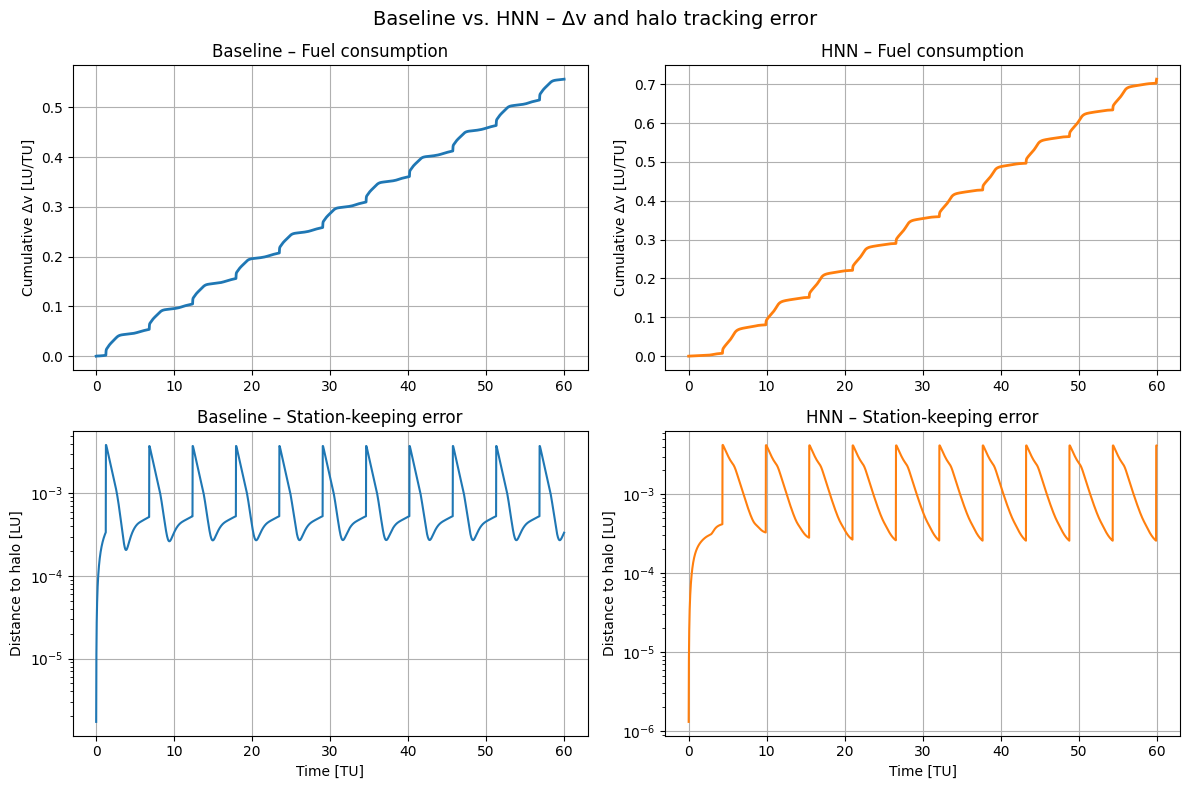

In [25]:
# ================================================================
# Cell 16 – Analysis: Baseline vs. HNN (Δv & halo error, 2x2)
# ================================================================

# ---------------------------------------------------------------
# Helper: load halo reference once
# ---------------------------------------------------------------
dim = env_baseline.dim  # 3D
halo_dir = PROJECT_ROOT / "sim_rl" / "cr3bp" / "reference_orbits" / "data"
halo_path = halo_dir / f"halo_{scenario_cfg.system}_{scenario_cfg.lagrange_point}.npy"

if halo_path.exists():
    halo = np.load(halo_path)
    halo_pos = halo[:, :dim]
    print(f"[INFO] Loaded halo reference: {halo_path.name}, length={len(halo_pos)}")
else:
    halo = None
    halo_pos = None
    print("[WARN] No halo reference file found – position error will be zero.")

# ---------------------------------------------------------------
# Helper: compute metrics for one rollout
# ---------------------------------------------------------------
def analyze_rollout(env, rollout, label: str = "run"):
    """
    Compute Δv and halo-tracking error metrics for a single rollout.
    """
    MAX_DV = env.max_dv
    print(f"[INFO] {label}: using MAX_DV = {MAX_DV}")

    t          = rollout["t"]
    pos_rot    = rollout["pos_rot_abs"]
    dv_actions = rollout["dv"]

    N   = len(t)
    dim = env.dim

    # Physical delta-v in normalized CR3BP units
    dv_phys = dv_actions * MAX_DV
    dv_norm = np.linalg.norm(dv_phys, axis=1)
    cum_dv  = np.cumsum(dv_norm)

    # Position error relative to halo reference
    if halo_pos is not None:
        # Simple nearest-phase alignment to halo reference
        dists0 = np.linalg.norm(halo_pos - pos_rot[0], axis=1)
        k0 = int(np.argmin(dists0))
        H = len(halo_pos)

        halo_pos_aligned = np.empty_like(pos_rot)
        for i in range(N):
            idx = (k0 + i) % H
            halo_pos_aligned[i] = halo_pos[idx]

        pos_err = np.linalg.norm(pos_rot - halo_pos_aligned, axis=1)
    else:
        pos_err = np.zeros_like(t)

    # Print basic statistics
    print("-" * 45)
    print(f"[STATS] {label}")
    print(f"  Total steps:                 {N}")
    print(f"  Total Δv (norm units):       {cum_dv[-1]:.6f}")
    print(f"  Mean Δv per step:            {dv_norm.mean():.6e}")
    print(f"  Mean position error to halo: {pos_err.mean():.6e}")
    print("-" * 45)

    return {
        "t": t,
        "dv_norm": dv_norm,
        "cum_dv": cum_dv,
        "pos_err": pos_err,
    }

# ---------------------------------------------------------------
# Compute metrics for Baseline & HNN
# ---------------------------------------------------------------
metrics_base = analyze_rollout(env_baseline, rollout_base, label="Baseline controlled")
metrics_hnn  = analyze_rollout(env_hnn,      rollout_hnn,  label="HNN controlled")

# ---------------------------------------------------------------
# 2x2 plot: top Δv, bottom error – left Baseline, right HNN
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex="row")

# --- Baseline: Δv ---
ax = axes[0, 0]
ax.plot(metrics_base["t"], metrics_base["cum_dv"], color="tab:blue", lw=2)
ax.set_ylabel("Cumulative Δv [LU/TU]")
ax.set_title("Baseline – Fuel consumption")
ax.grid(True)

# --- HNN: Δv ---
ax = axes[0, 1]
ax.plot(metrics_hnn["t"], metrics_hnn["cum_dv"], color="tab:orange", lw=2)
ax.set_ylabel("Cumulative Δv [LU/TU]")
ax.set_title("HNN – Fuel consumption")
ax.grid(True)

# --- Baseline: position error ---
ax = axes[1, 0]
ax.plot(metrics_base["t"], metrics_base["pos_err"], color="tab:blue")
ax.set_ylabel("Distance to halo [LU]")
ax.set_xlabel("Time [TU]")
ax.set_title("Baseline – Station-keeping error")
ax.set_yscale("log")
ax.grid(True)

# --- HNN: position error ---
ax = axes[1, 1]
ax.plot(metrics_hnn["t"], metrics_hnn["pos_err"], color="tab:orange")
ax.set_ylabel("Distance to halo [LU]")
ax.set_xlabel("Time [TU]")
ax.set_title("HNN – Station-keeping error")
ax.set_yscale("log")
ax.grid(True)

fig.suptitle("Baseline vs. HNN – Δv and halo tracking error", fontsize=14)
plt.tight_layout()
plt.show()


[UNITS] LU = 384400.0 km, TU = 375000.0 s
[UNITS] 1 (LU/TU) = 1.025067e+00 km/s = 1.025067e+03 m/s
-------------------------------------------------------
[PHYS STATS] Baseline controlled
  Total Δv:          570.383 m/s
  Mean Δv per step:  9.506e-02 m/s
  Mean pos error:    3.390e+02 km
-------------------------------------------------------
-------------------------------------------------------
[PHYS STATS] HNN controlled
  Total Δv:          730.619 m/s
  Mean Δv per step:  1.218e-01 m/s
  Mean pos error:    5.140e+02 km
-------------------------------------------------------


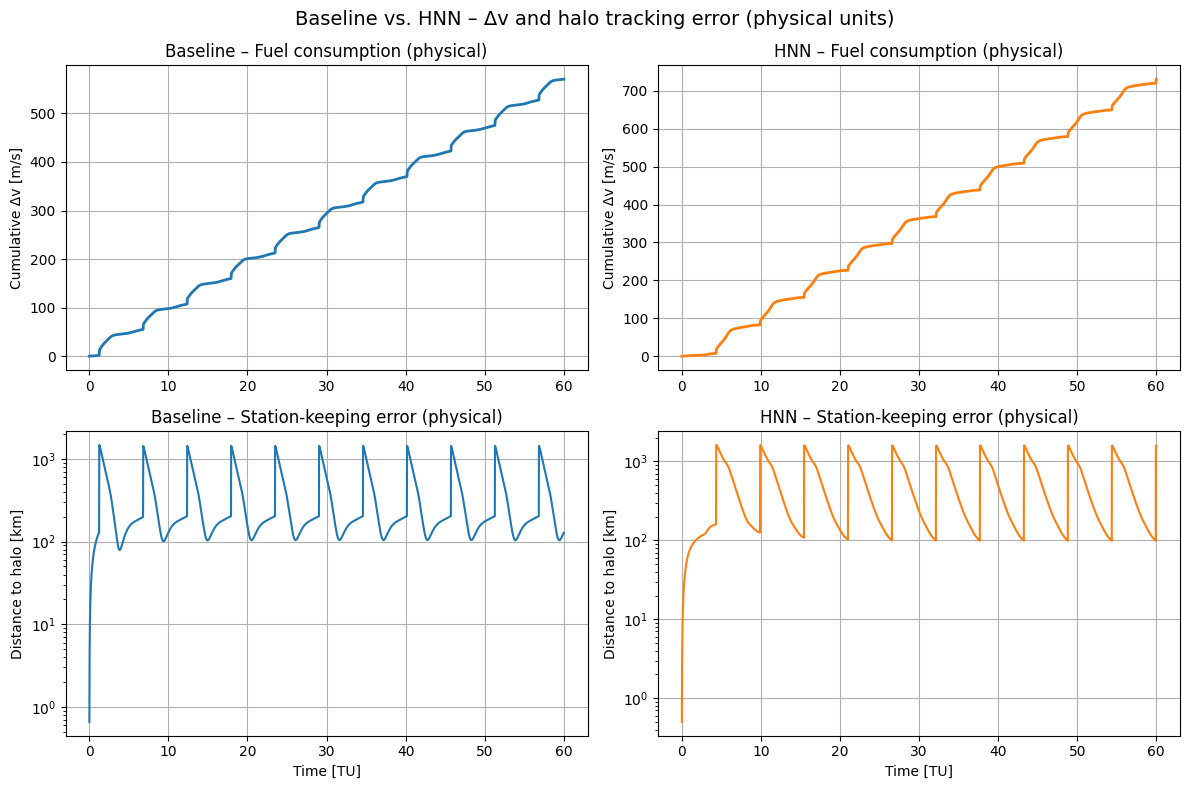

In [26]:
# ================================================================
# Cell 17 – Baseline vs. HNN in physical units (km, m/s)
# ================================================================

# ---------------------------------------------------------------
# 1. Units: CR3BP → physical (Earth–Moon default)
# ---------------------------------------------------------------
sys_cfg = SYSTEMS[scenario_cfg.system]

# Try to get scaling from the SYSTEMS configuration
LU_km = (
    sys_cfg.get("LU_km")
    or sys_cfg.get("length_unit_km")
    or sys_cfg.get("distance_unit_km")
)

TU_s = (
    sys_cfg.get("TU_s")
    or sys_cfg.get("time_unit_s")
    or sys_cfg.get("period_unit_s")
)

# Fallbacks (typical Earth–Moon CR3BP scaling)
if LU_km is None:
    LU_km = 384400.0  # Earth–Moon distance in km
if TU_s is None:
    # TU ≈ orbital period / (2π), rough Earth–Moon value
    TU_s = 375000.0   # ≈ 4.34 days

VEL_UNIT_km_s = LU_km / TU_s       # 1 (LU/TU) → km/s
VEL_UNIT_m_s  = VEL_UNIT_km_s * 1e3  # 1 (LU/TU) → m/s

print(f"[UNITS] LU = {LU_km:.1f} km, TU = {TU_s:.1f} s")
print(f"[UNITS] 1 (LU/TU) = {VEL_UNIT_km_s:.6e} km/s = {VEL_UNIT_m_s:.6e} m/s")

# ---------------------------------------------------------------
# 2. Helper: analyze rollout and convert to physical units
# ---------------------------------------------------------------
def analyze_rollout_phys(env, rollout, label: str = "run"):
    """
    Compute Δv and halo-tracking error in physical units (m/s, km)
    for a given rollout.
    """
    MAX_DV  = env.max_dv  # in LU/TU
    t       = rollout["t"]
    pos_rot = rollout["pos_rot_abs"]
    dv_act  = rollout["dv"]

    N   = len(t)
    dim = env.dim

    # Delta-v in normalized CR3BP units (LU/TU)
    dv_step_norm = np.linalg.norm(dv_act * MAX_DV, axis=1)
    cum_dv_norm  = np.cumsum(dv_step_norm)

    # Delta-v in m/s
    dv_step_ms = dv_step_norm * VEL_UNIT_m_s
    cum_dv_ms  = cum_dv_norm * VEL_UNIT_m_s

    # Position error relative to halo reference (then converted to km)
    halo_dir = PROJECT_ROOT / "sim_rl" / "cr3bp" / "reference_orbits" / "data"
    halo_path = halo_dir / f"halo_{scenario_cfg.system}_{scenario_cfg.lagrange_point}.npy"

    if halo_path.exists():
        halo = np.load(halo_path)
        halo_pos = halo[:, :dim]

        dists0 = np.linalg.norm(halo_pos - pos_rot[0], axis=1)
        k0 = int(np.argmin(dists0))
        H  = len(halo_pos)

        halo_pos_aligned = np.empty_like(pos_rot)
        for i in range(N):
            idx = (k0 + i) % H
            halo_pos_aligned[i] = halo_pos[idx]

        pos_err_LU = np.linalg.norm(pos_rot - halo_pos_aligned, axis=1)
    else:
        print(f"[WARN] No halo file at {halo_path}, using zero error for {label}.")
        pos_err_LU = np.zeros_like(t)

    pos_err_km = pos_err_LU * LU_km

    # Short statistics in physical units
    print("-" * 55)
    print(f"[PHYS STATS] {label}")
    print(f"  Total Δv:          {cum_dv_ms[-1]:.3f} m/s")
    print(f"  Mean Δv per step:  {dv_step_ms.mean():.3e} m/s")
    print(f"  Mean pos error:    {pos_err_km.mean():.3e} km")
    print("-" * 55)

    return {
        "t": t,
        "dv_step_ms": dv_step_ms,
        "cum_dv_ms": cum_dv_ms,
        "pos_err_km": pos_err_km,
    }

# ---------------------------------------------------------------
# 3. Analysis: Baseline & HNN
# ---------------------------------------------------------------
metrics_base_phys = analyze_rollout_phys(env_baseline, rollout_base, label="Baseline controlled")
metrics_hnn_phys  = analyze_rollout_phys(env_hnn,      rollout_hnn,  label="HNN controlled")

# ---------------------------------------------------------------
# 4. 2x2 plots in physical units (m/s, km)
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex="row")

# --- Baseline: cumulative Δv [m/s] ---
ax = axes[0, 0]
ax.plot(metrics_base_phys["t"], metrics_base_phys["cum_dv_ms"], color="tab:blue", lw=2)
ax.set_ylabel("Cumulative Δv [m/s]")
ax.set_title("Baseline – Fuel consumption (physical)")
ax.grid(True)

# --- HNN: cumulative Δv [m/s] ---
ax = axes[0, 1]
ax.plot(metrics_hnn_phys["t"], metrics_hnn_phys["cum_dv_ms"], color="tab:orange", lw=2)
ax.set_ylabel("Cumulative Δv [m/s]")
ax.set_title("HNN – Fuel consumption (physical)")
ax.grid(True)

# --- Baseline: position error [km] ---
ax = axes[1, 0]
ax.plot(metrics_base_phys["t"], metrics_base_phys["pos_err_km"], color="tab:blue")
ax.set_ylabel("Distance to halo [km]")
ax.set_xlabel("Time [TU]")
ax.set_title("Baseline – Station-keeping error (physical)")
ax.set_yscale("log")
ax.grid(True)

# --- HNN: position error [km] ---
ax = axes[1, 1]
ax.plot(metrics_hnn_phys["t"], metrics_hnn_phys["pos_err_km"], color="tab:orange")
ax.set_ylabel("Distance to halo [km]")
ax.set_xlabel("Time [TU]")
ax.set_title("HNN – Station-keeping error (physical)")
ax.set_yscale("log")
ax.grid(True)

fig.suptitle("Baseline vs. HNN – Δv and halo tracking error (physical units)", fontsize=14)
plt.tight_layout()
plt.show()
